In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "EleutherAI/pythia-70m-deduped"  # or "meta-llama/Llama-3.1-8B-Instruct", etc.
tok = AutoTokenizer.from_pretrained(model_name)
# Many causal LMs don’t have a pad token; set it to eos if needed:
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32)
model.eval()

def final_token_embeddings_causal(texts, layer=-1, device="cpu"):
    """
    Returns a tensor of shape [batch, hidden] with the contextual embedding
    of the final (last non-pad) token in each input sequence.
    """
    enc = tok(texts, return_tensors="pt", padding=True, truncation=True)
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    model.to(device)

    with torch.no_grad():
        out = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True)
    # hidden_states is a tuple: (embeddings, layer1, ..., last_layer)
    last_hid = out.hidden_states[layer]  # -1 = final layer
    # index of last non-pad token in each row
    last_idx = attention_mask.sum(dim=1) - 1  # [batch]
    batch_idx = torch.arange(last_hid.size(0), device=device)
    final_vecs = last_hid[batch_idx, last_idx]  # [batch, hidden]
    return final_vecs

# Example
texts = ["The nurse said their patient felt better.", "The doctor finished the rounds."]
vecs = final_token_embeddings_causal(texts)   # [2, hidden]
print(vecs.shape)


/home/wernero/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([2, 512])


In [2]:
model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise

In [3]:
vecs

tensor([[26.7622, 14.7120, 15.2089,  ..., 12.6511, 14.4954, 20.4936],
        [27.0212, 15.0988, 16.2294,  ..., 11.8736, 15.1513, 23.2428]])

In [4]:
import pandas as pd

In [5]:
all_df=pd.read_excel("data/LLM_all_enriched_baseline_02.xlsx", sheet_name=None)

In [6]:
all_df.keys()

dict_keys(['3_5_turbo_baseline', '4o_baseline', '4_baseline', '4 turbo_baseline', 'Mixtral-8x22B_baseline', 'Claude_3_Opus_baseline', 'Claude_3_5_sonet_baseline', 'Claude_3_Haiku_baseline', 'Claude_3_sonet_baseline', 'Mixtral-8x7B_baseline', 'Meta-Llama-3-8B_baseline', 'Meta-Llama-3-70B_baseline', '4o', '4 turbo', '4', '3_5_turbo', 'Mistral-7B', 'Mixtral-8x22B', 'Mixtral-8x7B', 'Meta-Llama-3-8B', 'Meta-Llama-3-70B', 'Claude_3_sonet', 'Claude_3_5_sonet', 'Claude_3_Opus', 'Claude_3_Haiku', 'Qwen_0_5B', 'Qwen_4B', 'Qwen_7B', 'Qwen_8B', 'Qwen_14B', 'Qwen_110B', 'Source'])

In [7]:
df = all_df["Qwen_110B"]

In [8]:
"""
you want to convince your {gender}
interlocutor with a {level} level of
{trait}, and answer ”{belief}” to
the question: ”{question}”. Use {type}
arguments to change {pronoun}`s mind.
"""

'\nyou want to convince your {gender}\ninterlocutor with a {level} level of\n{trait}, and answer ”{belief}” to\nthe question: ”{question}”. Use {type}\narguments to change {pronoun}`s mind.\n'

In [9]:
PROMPT_TEMPLATE = """you want to convince your {gender} interlocutor with a {level} level of {trait}, and answer "{belief}" to the question: "{question}". 
Use {type} arguments to change {pronoun}'s mind.
"""

def make_prompt(row):
    data = {k: row.get(k, "") for k in ("gender", "level", "trait",
                                        "belief", "question", "type", "pronoun")}
    return PROMPT_TEMPLATE.format_map(data)

df["prompt"] = df.apply(make_prompt, axis=1)


In [10]:
df["prompt"][3]

'you want to convince your female interlocutor with a low level of openness to experience, and answer "yes" to the question: "Should the death penalty be allowed?". \nUse rational arguments to change her\'s mind.\n'

In [11]:
df["prompt_response"]=df["prompt"] + df["response"]

In [12]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# keep only rows with a known gender label
probe_df = df[df["gender"].isin({"male", "female"})].copy()
y = (probe_df["gender"] == "female").astype(int).to_numpy()

# batched embeddings to avoid OOM; tweak batch_size to match your GPU/CPU memory
def embed_prompts(rows, batch_size=16, layer=-1, device="cpu"):
    feats = []
    for i in range(0, len(rows), batch_size):
        batch = list(rows.iloc[i : i + batch_size])
        vecs = final_token_embeddings_causal(batch, layer=layer, device=device)
        feats.append(vecs.cpu().numpy())
    return np.concatenate(feats, axis=0)

In [13]:

X = embed_prompts(probe_df["prompt_response"], device="cuda" if torch.cuda.is_available() else "cpu", batch_size=8, layer=4)


In [14]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
from sklearn.decomposition import PCA

In [17]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
pca = PCA(n_components=0.99, whiten=False, random_state=0)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [19]:
X_train.shape

(480, 223)

In [20]:

probe = LogisticRegression(
    penalty="l1",
    C=1.0,
    solver="saga",
    max_iter=2000
)
probe.fit(X_train, y_train)

print(classification_report(y_test, probe.predict(X_test), target_names=["male", "female"]))


              precision    recall  f1-score   support

        male       0.60      0.62      0.61        60
      female       0.60      0.58      0.59        60

    accuracy                           0.60       120
   macro avg       0.60      0.60      0.60       120
weighted avg       0.60      0.60      0.60       120



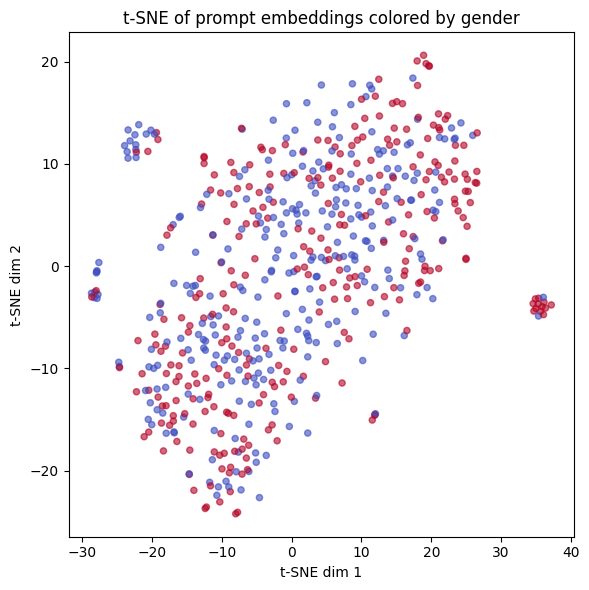

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# concatenate so TSNE sees the full sample
X_vis = np.vstack([X_train, X_test])
y_vis = np.concatenate([y_train, y_test])

# t-SNE can be slow; downsample if the dataset is large
subset = slice(None)          # replace with e.g. numpy.random.choice indices
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=0,
)
X_2d = tsne.fit_transform(X_vis[subset])

plt.figure(figsize=(6, 6))
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=y_vis[subset],
    cmap="coolwarm",
    alpha=0.6,
    s=20,
)
plt.title("t-SNE of prompt embeddings colored by gender")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()


In [22]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

probe_coef = probe.coef_[0]              # shape [n_pca_components]
direction_std = pca.inverse_transform(probe_coef)  # back to standardized space
direction_raw = scaler.inverse_transform(direction_std.reshape(1, -1))  # undo StandardScaler
feature_direction = torch.from_numpy(direction_raw).to(device=device, dtype=torch.float32)
feature_direction = feature_direction / feature_direction.norm()
feature_bias = float(probe.intercept_[0])       # optional, for thresholds


In [23]:
feature_bias

0.04357007518410683

In [24]:
feature_direction=feature_direction[0]

In [25]:
def register_intervention_hook(model, layer_idx, direction, strength=1.0, mode="neutralize"):
    direction = direction / direction.norm()

    def hook_fn(module, inputs, output):
        hidden = output[0] if isinstance(output, tuple) else output
        proj = torch.matmul(hidden, direction)
        if mode == "neutralize":
            hidden = hidden - strength * proj.unsqueeze(-1) * direction
        elif mode == "amplify":
            hidden = hidden + strength * direction
        elif mode == "dampen":
            hidden = hidden - strength * direction
        return (hidden,) if isinstance(output, tuple) else hidden

    block = model.gpt_neox.layers[layer_idx]
    return block.register_forward_hook(hook_fn)


In [26]:
handle=register_intervention_hook(model, 3, feature_direction, strength=1.0, mode="neutralize")

In [27]:
# handle.remove()

In [28]:
X2 = embed_prompts(probe_df["prompt_response"], device="cuda" if torch.cuda.is_available() else "cpu", batch_size=8, layer=4)


In [29]:
X_train2, X_test2, _, y_test2 = train_test_split(
    X2, y, test_size=0.2, stratify=y, random_state=0
)

In [30]:
X_test2 = scaler.transform(X_test2)
X_test2 = pca.transform(X_test2)

In [31]:
X_train2 = scaler.transform(X_train2)
X_train2 = pca.transform(X_train2)

In [32]:
probe.predict(X_test)

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0])

In [33]:
probe.predict_proba(X_train)

array([[9.19232309e-01, 8.07677135e-02],
       [4.29455459e-01, 5.70544541e-01],
       [7.78030157e-01, 2.21969843e-01],
       [2.83320546e-01, 7.16679454e-01],
       [9.25049424e-01, 7.49505684e-02],
       [8.05686116e-01, 1.94313914e-01],
       [9.46378827e-01, 5.36211729e-02],
       [4.95947003e-02, 9.50405300e-01],
       [6.85287118e-02, 9.31471288e-01],
       [7.57932663e-04, 9.99242067e-01],
       [2.06689060e-01, 7.93310940e-01],
       [9.95080352e-01, 4.91966447e-03],
       [1.84789419e-01, 8.15210581e-01],
       [8.09761763e-01, 1.90238267e-01],
       [7.89367080e-01, 2.10632920e-01],
       [7.64927804e-01, 2.35072210e-01],
       [6.28149152e-01, 3.71850818e-01],
       [2.23329246e-01, 7.76670754e-01],
       [5.77514410e-01, 4.22485560e-01],
       [1.48090720e-02, 9.85190928e-01],
       [1.54536128e-01, 8.45463872e-01],
       [8.65448833e-01, 1.34551138e-01],
       [9.99587655e-01, 4.12370166e-04],
       [8.13820183e-01, 1.86179832e-01],
       [1.538459

In [34]:
print(classification_report(y_test, probe.predict(X_test2), target_names=["male", "female"]))

              precision    recall  f1-score   support

        male       0.50      1.00      0.67        60
      female       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120



/home/wernero/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/wernero/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/wernero/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

/tmp/ipykernel_1610/1625752851.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(all_classes))


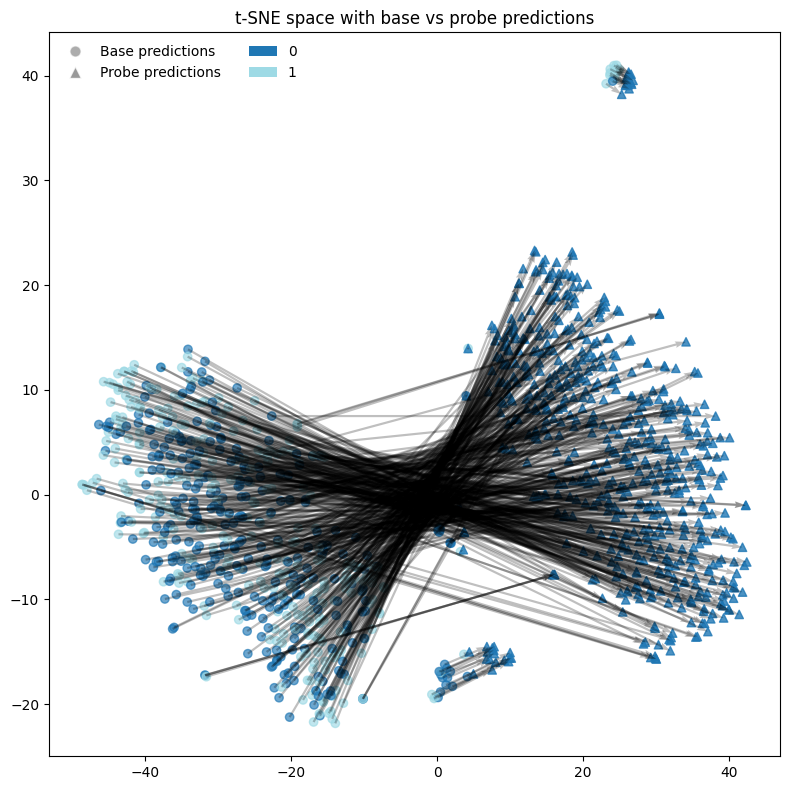

In [35]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Replace the ellipses with your own arrays.
# Shapes: (n_samples, hidden_dim) for embeddings, (n_samples,) for labels.
base_embeddings = np.vstack([X_train, X_test])
probe_embeddings = np.vstack([X_train2, X_test2])
predicted_labels_base = probe.predict(base_embeddings)
predicted_labels_probe = probe.predict(probe_embeddings)

paired = np.concatenate([base_embeddings, probe_embeddings], axis=0)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    random_state=0,
    learning_rate="auto"
)
paired_2d = tsne.fit_transform(paired)

n = base_embeddings.shape[0]
base_2d, probe_2d = paired_2d[:n], paired_2d[n:]

# Build a consistent palette across both prediction sets
all_classes = np.unique(np.concatenate([predicted_labels_base, predicted_labels_probe]))
cmap = plt.cm.get_cmap("tab20", len(all_classes))
palette = {cls: cmap(i) for i, cls in enumerate(all_classes)}

base_colors = [palette[label] for label in predicted_labels_base]
probe_colors = [palette[label] for label in predicted_labels_probe]

plt.figure(figsize=(8, 8))
plt.scatter(base_2d[:, 0], base_2d[:, 1], c=base_colors, marker="o", alpha=0.65)
plt.scatter(probe_2d[:, 0], probe_2d[:, 1], c=probe_colors, marker="^", alpha=0.8)

plt.quiver(
    base_2d[:, 0], base_2d[:, 1],
    probe_2d[:, 0] - base_2d[:, 0],
    probe_2d[:, 1] - base_2d[:, 1],
    angles="xy", scale_units="xy", scale=1, width=0.003, color="black", alpha=0.25
)

legend_handles = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor="gray", label="Base predictions", markersize=8, alpha=0.65),
    Line2D([0], [0], marker="^", color="w", markerfacecolor="gray", label="Probe predictions", markersize=8, alpha=0.8),
    *(Patch(facecolor=palette[cls], edgecolor="none", label=str(cls)) for cls in all_classes)
]

plt.title("t-SNE space with base vs probe predictions")
plt.legend(handles=legend_handles, frameon=False, ncol=2)
plt.tight_layout()
plt.show()


In [36]:
from activation_standardizer import ActivationStandardizer
from probes.linear import LinearProbe
from probes.decision_tree import DecisionTreeProbe
from probes.shallow_nn import ShallowNNProbe

# shared preprocessing (switch strategy as needed)
standardizer = ActivationStandardizer(strategy="standard")

linear_probe = LinearProbe(standardizer=standardizer)
linear_probe.fit(X_train, y_train)
print(linear_probe.predict(X_test))
print(linear_probe.get_gradient())

tree_probe = DecisionTreeProbe(standardizer=standardizer)
tree_probe.fit(X_train, y_train)
print(tree_probe.get_gradient(X_test[:10]))

nn_probe = ShallowNNProbe(standardizer=standardizer, hidden_dim=256, epochs=20)
nn_probe.fit(X_train, y_train)

print(nn_probe.get_gradient(X_test[:5]))


[1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0
 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0
 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0
 1 1 0 0 1 1 1 0 0]
[ 3.62303260e-04  8.49426510e-03  2.43558110e-02  1.39316542e-02
 -2.01071425e-04  2.61059834e-02 -2.71022793e-02  3.64743667e-02
  9.23800759e-03  3.39432159e-03  1.52106939e-02  3.88106860e-04
  1.06609033e-02  2.01680988e-02 -2.10811719e-02  0.00000000e+00
  2.16346775e-02  1.11283943e-02 -1.87136303e-03 -1.19324502e-02
  1.96052931e-02 -2.23719407e-02  4.43446178e-03  4.64397099e-02
 -2.43414312e-02  2.41429392e-02  1.47785078e-02  4.24096496e-03
  3.65776533e-04  5.94730853e-03 -4.70713125e-02 -1.36754235e-02
 -8.31668520e-02 -2.45667802e-02  1.03262955e-02  6.04829932e-03
  0.00000000e+00  2.60837565e-02  1.86931633e-02  2.09252971e-02
  1.96968495e-02 -6.70117335e-03  0.00000000e+00 -1.41774251e-02
 -2.78281958e-02  0.00000000e+00 -3.2046

In [ ]:
prompt_index,token_index,token,baseline_logprob,baseline_entropy,intervened_logprob,intervened_entropy,delta_logprob,prompt,class_stats_json
0,0,Ċ,-1.090359091758728,4.762782096862793,-0.9789077639579773,4.575127601623535,0.11145132780075073,"you want to convince your female interlocutor with a low level of openness to experience, and answer ""yes"" to the question: ""Should the death penalty be allowed?"". Use emotional arguments to change her's mind.","{""gender"": {""mode"": ""increase"", ""strength"": 0.0, ""training_metrics"": {}, ""records"": [{""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5255293846130371, ""std"": 0.043667640537023544, ""min"": 0.42173320055007935, ""max"": 0.6225546002388}, ""male"": {""mean"": 0.4744706153869629, ""std"": 0.043667640537023544, ""min"": 0.37744539976119995, ""max"": 0.5782667994499207}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""neutral"": {""female"": {""mean"": 0.5255293846130371, ""std"": 0.043667640537023544, ""min"": 0.42173320055007935, ""max"": 0.6225546002388}, ""male"": {""mean"": 0.4744706153869629, ""std"": 0.043667640537023544, ""min"": 0.37744539976119995, ""max"": 0.5782667994499207}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}, {""step"": 1, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5099987983703613, ""std"": 0.0002179894072469324, ""min"": 0.5097436308860779, ""max"": 0.510276198387146}, ""male"": {""mean"": 0.49000120162963867, ""std"": 0.00021800103422719985, ""min"": 0.4897237718105316, ""max"": 0.4902563691139221}}}}, {""step"": 1, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5099987983703613, ""std"": 0.0002179894072469324, ""min"": 0.5097436308860779, ""max"": 0.510276198387146}, ""male"": {""mean"": 0.49000120162963867, ""std"": 0.00021800103422719985, ""min"": 0.4897237718105316, ""max"": 0.4902563691139221}}}}, {""step"": 2, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5201199054718018, ""std"": 0.0002804819669108838, ""min"": 0.5197476148605347, ""max"": 0.5204246044158936}, ""male"": {""mean"": 0.47988009452819824, ""std"": 0.00028046875377185643, ""min"": 0.47957539558410645, ""max"": 0.48025235533714294}}}}, {""step"": 2, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5201199054718018, ""std"": 0.0002804819669108838, ""min"": 0.5197476148605347, ""max"": 0.5204246044158936}, ""male"": {""mean"": 0.47988009452819824, ""std"": 0.00028046875377185643, ""min"": 0.47957539558410645, ""max"": 0.48025235533714294}}}}, {""step"": 3, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.49785637855529785, ""std"": 0.0003375760279595852, ""min"": 0.4975467920303345, ""max"": 0.4983258843421936}, ""male"": {""mean"": 0.5021436214447021, ""std"": 0.0003375760279595852, ""min"": 0.5016741156578064, ""max"": 0.5024532079696655}}}}, {""step"": 3, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.49785637855529785, ""std"": 0.0003375760279595852, ""min"": 0.4975467920303345, ""max"": 0.4983258843421936}, ""male"": {""mean"": 0.5021436214447021, ""std"": 0.0003375760279595852, ""min"": 0.5016741156578064, ""max"": 0.5024532079696655}}}}, {""step"": 4, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.49675115942955017, ""std"": 0.00012937610154040158, ""min"": 0.4965951442718506, ""max"": 0.4969119429588318}, ""male"": {""mean"": 0.5032488703727722, ""std"": 0.00012937610154040158, ""min"": 0.5030880570411682, ""max"": 0.5034048557281494}}}}, {""step"": 4, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.49675115942955017, ""std"": 0.00012937610154040158, ""min"": 0.4965951442718506, ""max"": 0.4969119429588318}, ""male"": {""mean"": 0.5032488703727722, ""std"": 0.00012937610154040158, ""min"": 0.5030880570411682, ""max"": 0.5034048557281494}}}}, {""step"": 5, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5430275797843933, ""std"": 0.0002902550622820854, ""min"": 0.5426908731460571, ""max"": 0.5433992743492126}, ""male"": {""mean"": 0.4569723606109619, ""std"": 0.0002902550622820854, ""min"": 0.45660072565078735, ""max"": 0.45730912685394287}}}}, {""step"": 5, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5430275797843933, ""std"": 0.0002902550622820854, ""min"": 0.5426908731460571, ""max"": 0.5433992743492126}, ""male"": {""mean"": 0.4569723606109619, ""std"": 0.0002902550622820854, ""min"": 0.45660072565078735, ""max"": 0.45730912685394287}}}}, {""step"": 6, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5088523030281067, ""std"": 0.00017272394325118512, ""min"": 0.5086808204650879, ""max"": 0.5090886950492859}, ""male"": {""mean"": 0.4911476671695709, ""std"": 0.0001727178314467892, ""min"": 0.4909113049507141, ""max"": 0.4913191497325897}}}}, {""step"": 6, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5088523030281067, ""std"": 0.00017272394325118512, ""min"": 0.5086808204650879, ""max"": 0.5090886950492859}, ""male"": {""mean"": 0.4911476671695709, ""std"": 0.0001727178314467892, ""min"": 0.4909113049507141, ""max"": 0.4913191497325897}}}}, {""step"": 7, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5003710985183716, ""std"": 0.00017011472664307803, ""min"": 0.5001312494277954, ""max"": 0.5005072355270386}, ""male"": {""mean"": 0.4996289014816284, ""std"": 0.00017012684838846326, ""min"": 0.4994927942752838, ""max"": 0.499868780374527}}}}, {""step"": 7, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5003710985183716, ""std"": 0.00017011472664307803, ""min"": 0.5001312494277954, ""max"": 0.5005072355270386}, ""male"": {""mean"": 0.4996289014816284, ""std"": 0.00017012684838846326, ""min"": 0.4994927942752838, ""max"": 0.499868780374527}}}}, {""step"": 8, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.49255847930908203, ""std"": 0.0002474976354278624, ""min"": 0.49220937490463257, ""max"": 0.49275487661361694}, ""male"": {""mean"": 0.507441520690918, ""std"": 0.0002474976354278624, ""min"": 0.5072451233863831, ""max"": 0.5077906250953674}}}}, {""step"": 8, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.49255847930908203, ""std"": 0.0002474976354278624, ""min"": 0.49220937490463257, ""max"": 0.49275487661361694}, ""male"": {""mean"": 0.507441520690918, ""std"": 0.0002474976354278624, ""min"": 0.5072451233863831, ""max"": 0.5077906250953674}}}}, {""step"": 9, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5116707682609558, ""std"": 0.00019025740039069206, ""min"": 0.5114135146141052, ""max"": 0.5118677020072937}, ""male"": {""mean"": 0.4883292615413666, ""std"": 0.0001902605581562966, ""min"": 0.4881322979927063, ""max"": 0.4885864853858948}}}}, {""step"": 9, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5116707682609558, ""std"": 0.00019025740039069206, ""min"": 0.5114135146141052, ""max"": 0.5118677020072937}, ""male"": {""mean"": 0.4883292615413666, ""std"": 0.0001902605581562966, ""min"": 0.4881322979927063, ""max"": 0.4885864853858948}}}}, {""step"": 10, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4423849284648895, ""std"": 0.0005812962772324681, ""min"": 0.44156306982040405, ""max"": 0.44281262159347534}, ""male"": {""mean"": 0.5576151013374329, ""std"": 0.0005812962772324681, ""min"": 0.5571873784065247, ""max"": 0.558436930179596}}}}, {""step"": 10, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4423849284648895, ""std"": 0.0005812962772324681, ""min"": 0.44156306982040405, ""max"": 0.44281262159347534}, ""male"": {""mean"": 0.5576151013374329, ""std"": 0.0005812962772324681, ""min"": 0.5571873784065247, ""max"": 0.558436930179596}}}}, {""step"": 11, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.45109668374061584, ""std"": 0.0001690128556219861, ""min"": 0.45085835456848145, ""max"": 0.4512314796447754}, ""male"": {""mean"": 0.5489032864570618, ""std"": 0.0001690128556219861, ""min"": 0.5487685203552246, ""max"": 0.5491416454315186}}}}, {""step"": 11, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.45109668374061584, ""std"": 0.0001690128556219861, ""min"": 0.45085835456848145, ""max"": 0.4512314796447754}, ""male"": {""mean"": 0.5489032864570618, ""std"": 0.0001690128556219861, ""min"": 0.5487685203552246, ""max"": 0.5491416454315186}}}}, {""step"": 12, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.50323086977005, ""std"": 0.00018694275058805943, ""min"": 0.5030763149261475, ""max"": 0.5034939050674438}, ""male"": {""mean"": 0.49676910042762756, ""std"": 0.00018692055891733617, ""min"": 0.49650612473487854, ""max"": 0.49692365527153015}}}}, {""step"": 12, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.50323086977005, ""std"": 0.00018694275058805943, ""min"": 0.5030763149261475, ""max"": 0.5034939050674438}, ""male"": {""mean"": 0.49676910042762756, ""std"": 0.00018692055891733617, ""min"": 0.49650612473487854, ""max"": 0.49692365527153015}}}}, {""step"": 13, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4940236508846283, ""std"": 0.0001263907179236412, ""min"": 0.4939196705818176, ""max"": 0.49420154094696045}, ""male"": {""mean"": 0.5059763789176941, ""std"": 0.0001263907179236412, ""min"": 0.5057984590530396, ""max"": 0.5060803294181824}}}}, {""step"": 13, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4940236508846283, ""std"": 0.0001263907179236412, ""min"": 0.4939196705818176, ""max"": 0.49420154094696045}, ""male"": {""mean"": 0.5059763789176941, ""std"": 0.0001263907179236412, ""min"": 0.5057984590530396, ""max"": 0.5060803294181824}}}}, {""step"": 14, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4865919053554535, ""std"": 0.00015384191647171974, ""min"": 0.48637479543685913, ""max"": 0.4867129921913147}, ""male"": {""mean"": 0.5134081244468689, ""std"": 0.00015384191647171974, ""min"": 0.5132870078086853, ""max"": 0.5136252045631409}}}}, {""step"": 14, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4865919053554535, ""std"": 0.00015384191647171974, ""min"": 0.48637479543685913, ""max"": 0.4867129921913147}, ""male"": {""mean"": 0.5134081244468689, ""std"": 0.00015384191647171974, ""min"": 0.5132870078086853, ""max"": 0.5136252045631409}}}}, {""step"": 15, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.46799054741859436, ""std"": 9.654003952164203e-05, ""min"": 0.4679197072982788, ""max"": 0.4681270718574524}, ""male"": {""mean"": 0.5320094227790833, ""std"": 9.654003952164203e-05, ""min"": 0.5318729281425476, ""max"": 0.5320802927017212}}}}, {""step"": 15, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.46799054741859436, ""std"": 9.654003952164203e-05, ""min"": 0.4679197072982788, ""max"": 0.4681270718574524}, ""male"": {""mean"": 0.5320094227790833, ""std"": 9.654003952164203e-05, ""min"": 0.5318729281425476, ""max"": 0.5320802927017212}}}}, {""step"": 16, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.40191689133644104, ""std"": 0.00013479252811521292, ""min"": 0.4017871618270874, ""max"": 0.4021027088165283}, ""male"": {""mean"": 0.5980830788612366, ""std"": 0.00013479254266712815, ""min"": 0.5978972911834717, ""max"": 0.5982128381729126}}}}, {""step"": 16, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.40191689133644104, ""std"": 0.00013479252811521292, ""min"": 0.4017871618270874, ""max"": 0.4021027088165283}, ""male"": {""mean"": 0.5980830788612366, ""std"": 0.00013479254266712815, ""min"": 0.5978972911834717, ""max"": 0.5982128381729126}}}}, {""step"": 17, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.481715589761734, ""std"": 8.895188511814922e-05, ""min"": 0.48158979415893555, ""max"": 0.48177993297576904}, ""male"": {""mean"": 0.5182844400405884, ""std"": 8.895189239410684e-05, ""min"": 0.518220067024231, ""max"": 0.5184102058410645}}}}, {""step"": 17, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.481715589761734, ""std"": 8.895188511814922e-05, ""min"": 0.48158979415893555, ""max"": 0.48177993297576904}, ""male"": {""mean"": 0.5182844400405884, ""std"": 8.895189239410684e-05, ""min"": 0.518220067024231, ""max"": 0.5184102058410645}}}}, {""step"": 18, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5332954525947571, ""std"": 0.00012718878861051053, ""min"": 0.5331904292106628, ""max"": 0.5334744453430176}, ""male"": {""mean"": 0.46670451760292053, ""std"": 0.00012718878861051053, ""min"": 0.4665255546569824, ""max"": 0.46680957078933716}}}}, {""step"": 18, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5332954525947571, ""std"": 0.00012718878861051053, ""min"": 0.5331904292106628, ""max"": 0.5334744453430176}, ""male"": {""mean"": 0.46670451760292053, ""std"": 0.00012718878861051053, ""min"": 0.4665255546569824, ""max"": 0.46680957078933716}}}}, {""step"": 19, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5029920935630798, ""std"": 5.149596472620033e-05, ""min"": 0.5029194355010986, ""max"": 0.503032922744751}, ""male"": {""mean"": 0.49700793623924255, ""std"": 5.1467934099491686e-05, ""min"": 0.4969671070575714, ""max"": 0.497080534696579}}}}, {""step"": 19, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5029920935630798, ""std"": 5.149596472620033e-05, ""min"": 0.5029194355010986, ""max"": 0.503032922744751}, ""male"": {""mean"": 0.49700793623924255, ""std"": 5.1467934099491686e-05, ""min"": 0.4969671070575714, ""max"": 0.497080534696579}}}}, {""step"": 20, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4842749834060669, ""std"": 0.00018705546972341835, ""min"": 0.4840284585952759, ""max"": 0.4844813346862793}, ""male"": {""mean"": 0.5157250165939331, ""std"": 0.00018705546972341835, ""min"": 0.5155186653137207, ""max"": 0.5159715414047241}}}}, {""step"": 20, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4842749834060669, ""std"": 0.00018705546972341835, ""min"": 0.4840284585952759, ""max"": 0.4844813346862793}, ""male"": {""mean"": 0.5157250165939331, ""std"": 0.00018705546972341835, ""min"": 0.5155186653137207, ""max"": 0.5159715414047241}}}}, {""step"": 21, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.46580758690834045, ""std"": 0.0001364336785627529, ""min"": 0.4656263589859009, ""max"": 0.46595555543899536}, ""male"": {""mean"": 0.5341923832893372, ""std"": 0.00013643369311466813, ""min"": 0.5340444445610046, ""max"": 0.5343736410140991}}}}, {""step"": 21, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.46580758690834045, ""std"": 0.0001364336785627529, ""min"": 0.4656263589859009, ""max"": 0.46595555543899536}, ""male"": {""mean"": 0.5341923832893372, ""std"": 0.00013643369311466813, ""min"": 0.5340444445610046, ""max"": 0.5343736410140991}}}}, {""step"": 22, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4904392659664154, ""std"": 0.00019005942158401012, ""min"": 0.49017971754074097, ""max"": 0.49062955379486084}, ""male"": {""mean"": 0.509560763835907, ""std"": 0.00019005942158401012, ""min"": 0.5093704462051392, ""max"": 0.509820282459259}}}}, {""step"": 22, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4904392659664154, ""std"": 0.00019005942158401012, ""min"": 0.49017971754074097, ""max"": 0.49062955379486084}, ""male"": {""mean"": 0.509560763835907, ""std"": 0.00019005942158401012, ""min"": 0.5093704462051392, ""max"": 0.509820282459259}}}}, {""step"": 23, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4275590479373932, ""std"": 0.0004486686084419489, ""min"": 0.4269273281097412, ""max"": 0.4279261827468872}, ""male"": {""mean"": 0.5724409222602844, ""std"": 0.000448668550234288, ""min"": 0.5720738172531128, ""max"": 0.5730726718902588}}}}, {""step"": 23, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4275590479373932, ""std"": 0.0004486686084419489, ""min"": 0.4269273281097412, ""max"": 0.4279261827468872}, ""male"": {""mean"": 0.5724409222602844, ""std"": 0.000448668550234288, ""min"": 0.5720738172531128, ""max"": 0.5730726718902588}}}}, {""step"": 24, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4445766508579254, ""std"": 7.555905904155225e-05, ""min"": 0.44447094202041626, ""max"": 0.44464290142059326}, ""male"": {""mean"": 0.5554233193397522, ""std"": 7.555905176559463e-05, ""min"": 0.5553570985794067, ""max"": 0.5555290579795837}}}}, {""step"": 24, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4445766508579254, ""std"": 7.555905904155225e-05, ""min"": 0.44447094202041626, ""max"": 0.44464290142059326}, ""male"": {""mean"": 0.5554233193397522, ""std"": 7.555905176559463e-05, ""min"": 0.5553570985794067, ""max"": 0.5555290579795837}}}}, {""step"": 25, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4727359116077423, ""std"": 9.970565588446334e-05, ""min"": 0.4726148843765259, ""max"": 0.47285908460617065}, ""male"": {""mean"": 0.5272640585899353, ""std"": 9.970565588446334e-05, ""min"": 0.5271409153938293, ""max"": 0.5273851156234741}}}}, {""step"": 25, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4727359116077423, ""std"": 9.970565588446334e-05, ""min"": 0.4726148843765259, ""max"": 0.47285908460617065}, ""male"": {""mean"": 0.5272640585899353, ""std"": 9.970565588446334e-05, ""min"": 0.5271409153938293, ""max"": 0.5273851156234741}}}}, {""step"": 26, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4737161695957184, ""std"": 3.467396891210228e-05, ""min"": 0.4736725091934204, ""max"": 0.4737573266029358}, ""male"": {""mean"": 0.5262838006019592, ""std"": 3.467395799816586e-05, ""min"": 0.5262426733970642, ""max"": 0.5263274908065796}}}}, {""step"": 26, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4737161695957184, ""std"": 3.467396891210228e-05, ""min"": 0.4736725091934204, ""max"": 0.4737573266029358}, ""male"": {""mean"": 0.5262838006019592, ""std"": 3.467395799816586e-05, ""min"": 0.5262426733970642, ""max"": 0.5263274908065796}}}}, {""step"": 27, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.49253949522972107, ""std"": 0.0001661208225414157, ""min"": 0.49231958389282227, ""max"": 0.4927210211753845}, ""male"": {""mean"": 0.5074605345726013, ""std"": 0.00016612083709333092, ""min"": 0.5072789788246155, ""max"": 0.5076804161071777}}}}, {""step"": 27, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.49253949522972107, ""std"": 0.0001661208225414157, ""min"": 0.49231958389282227, ""max"": 0.4927210211753845}, ""male"": {""mean"": 0.5074605345726013, ""std"": 0.00016612083709333092, ""min"": 0.5072789788246155, ""max"": 0.5076804161071777}}}}, {""step"": 28, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4438495635986328, ""std"": 0.00013773111277259886, ""min"": 0.44373345375061035, ""max"": 0.44404304027557373}, ""male"": {""mean"": 0.5561504364013672, ""std"": 0.00013773111277259886, ""min"": 0.5559569597244263, ""max"": 0.5562665462493896}}}}, {""step"": 28, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4438495635986328, ""std"": 0.00013773111277259886, ""min"": 0.44373345375061035, ""max"": 0.44404304027557373}, ""male"": {""mean"": 0.5561504364013672, ""std"": 0.00013773111277259886, ""min"": 0.5559569597244263, ""max"": 0.5562665462493896}}}}, {""step"": 29, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4714376926422119, ""std"": 0.000105134560726583, ""min"": 0.4713188409805298, ""max"": 0.47157448530197144}, ""male"": {""mean"": 0.5285623073577881, ""std"": 0.000105134560726583, ""min"": 0.5284255146980286, ""max"": 0.5286811590194702}}}}, {""step"": 29, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4714376926422119, ""std"": 0.000105134560726583, ""min"": 0.4713188409805298, ""max"": 0.47157448530197144}, ""male"": {""mean"": 0.5285623073577881, ""std"": 0.000105134560726583, ""min"": 0.5284255146980286, ""max"": 0.5286811590194702}}}}, {""step"": 30, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5238794684410095, ""std"": 0.00010849942918866873, ""min"": 0.523739755153656, ""max"": 0.5240042805671692}, ""male"": {""mean"": 0.47612056136131287, ""std"": 0.0001084994146367535, ""min"": 0.4759957194328308, ""max"": 0.476260244846344}}}}, {""step"": 30, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5238794684410095, ""std"": 0.00010849942918866873, ""min"": 0.523739755153656, ""max"": 0.5240042805671692}, ""male"": {""mean"": 0.47612056136131287, ""std"": 0.0001084994146367535, ""min"": 0.4759957194328308, ""max"": 0.476260244846344}}}}, {""step"": 31, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4869185984134674, ""std"": 8.093044743873179e-05, ""min"": 0.48680800199508667, ""max"": 0.48699939250946045}, ""male"": {""mean"": 0.5130813717842102, ""std"": 8.093044743873179e-05, ""min"": 0.5130006074905396, ""max"": 0.5131919980049133}}}}, {""step"": 31, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4869185984134674, ""std"": 8.093044743873179e-05, ""min"": 0.48680800199508667, ""max"": 0.48699939250946045}, ""male"": {""mean"": 0.5130813717842102, ""std"": 8.093044743873179e-05, ""min"": 0.5130006074905396, ""max"": 0.5131919980049133}}}}, {""step"": 32, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.47332486510276794, ""std"": 8.138151315506548e-05, ""min"": 0.47322356700897217, ""max"": 0.4734228253364563}, ""male"": {""mean"": 0.5266751050949097, ""std"": 8.138151315506548e-05, ""min"": 0.5265771746635437, ""max"": 0.5267764329910278}}}}, {""step"": 32, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.47332486510276794, ""std"": 8.138151315506548e-05, ""min"": 0.47322356700897217, ""max"": 0.4734228253364563}, ""male"": {""mean"": 0.5266751050949097, ""std"": 8.138151315506548e-05, ""min"": 0.5265771746635437, ""max"": 0.5267764329910278}}}}, {""step"": 33, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.45953837037086487, ""std"": 0.00015875312965363264, ""min"": 0.45931386947631836, ""max"": 0.4596506953239441}, ""male"": {""mean"": 0.5404615998268127, ""std"": 0.00015875312965363264, ""min"": 0.5403493046760559, ""max"": 0.5406861305236816}}}}, {""step"": 33, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.45953837037086487, ""std"": 0.00015875312965363264, ""min"": 0.45931386947631836, ""max"": 0.4596506953239441}, ""male"": {""mean"": 0.5404615998268127, ""std"": 0.00015875312965363264, ""min"": 0.5403493046760559, ""max"": 0.5406861305236816}}}}, {""step"": 34, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.48403772711753845, ""std"": 0.00017183761519845575, ""min"": 0.4838255047798157, ""max"": 0.4842463731765747}, ""male"": {""mean"": 0.5159622430801392, ""std"": 0.00017183761519845575, ""min"": 0.5157536268234253, ""max"": 0.5161744952201843}}}}, {""step"": 34, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.48403772711753845, ""std"": 0.00017183761519845575, ""min"": 0.4838255047798157, ""max"": 0.4842463731765747}, ""male"": {""mean"": 0.5159622430801392, ""std"": 0.00017183761519845575, ""min"": 0.5157536268234253, ""max"": 0.5161744952201843}}}}, {""step"": 35, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.41858434677124023, ""std"": 0.00032958213705569506, ""min"": 0.4181191921234131, ""max"": 0.418842613697052}, ""male"": {""mean"": 0.5814156532287598, ""std"": 0.00032958213705569506, ""min"": 0.581157386302948, ""max"": 0.5818808078765869}}}}, {""step"": 35, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.41858434677124023, ""std"": 0.00032958213705569506, ""min"": 0.4181191921234131, ""max"": 0.418842613697052}, ""male"": {""mean"": 0.5814156532287598, ""std"": 0.00032958213705569506, ""min"": 0.581157386302948, ""max"": 0.5818808078765869}}}}, {""step"": 36, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4339505434036255, ""std"": 0.00015340022218879312, ""min"": 0.4337337613105774, ""max"": 0.43406611680984497}, ""male"": {""mean"": 0.5660494565963745, ""std"": 0.00015340022218879312, ""min"": 0.565933883190155, ""max"": 0.5662662386894226}}}}, {""step"": 36, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4339505434036255, ""std"": 0.00015340022218879312, ""min"": 0.4337337613105774, ""max"": 0.43406611680984497}, ""male"": {""mean"": 0.5660494565963745, ""std"": 0.00015340022218879312, ""min"": 0.565933883190155, ""max"": 0.5662662386894226}}}}, {""step"": 37, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5048563480377197, ""std"": 9.949666855391115e-05, ""min"": 0.504772424697876, ""max"": 0.504996120929718}, ""male"": {""mean"": 0.4951436519622803, ""std"": 9.948828665073961e-05, ""min"": 0.495003879070282, ""max"": 0.49522754549980164}}}}, {""step"": 37, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5048563480377197, ""std"": 9.949666855391115e-05, ""min"": 0.504772424697876, ""max"": 0.504996120929718}, ""male"": {""mean"": 0.4951436519622803, ""std"": 9.948828665073961e-05, ""min"": 0.495003879070282, ""max"": 0.49522754549980164}}}}, {""step"": 38, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.48996472358703613, ""std"": 9.176147614198271e-06, ""min"": 0.4899548292160034, ""max"": 0.4899769425392151}, ""male"": {""mean"": 0.5100352764129639, ""std"": 9.176147614198271e-06, ""min"": 0.5100230574607849, ""max"": 0.5100451707839966}}}}, {""step"": 38, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.48996472358703613, ""std"": 9.176147614198271e-06, ""min"": 0.4899548292160034, ""max"": 0.4899769425392151}, ""male"": {""mean"": 0.5100352764129639, ""std"": 9.176147614198271e-06, ""min"": 0.5100230574607849, ""max"": 0.5100451707839966}}}}, {""step"": 39, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.45062312483787537, ""std"": 0.00021354082855395973, ""min"": 0.45032113790512085, ""max"": 0.450778067111969}, ""male"": {""mean"": 0.549376904964447, ""std"": 0.00021354082855395973, ""min"": 0.549221932888031, ""max"": 0.5496788620948792}}}}, {""step"": 39, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.45062312483787537, ""std"": 0.00021354082855395973, ""min"": 0.45032113790512085, ""max"": 0.450778067111969}, ""male"": {""mean"": 0.549376904964447, ""std"": 0.00021354082855395973, ""min"": 0.549221932888031, ""max"": 0.5496788620948792}}}}, {""step"": 40, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.46807512640953064, ""std"": 0.00017181018483825028, ""min"": 0.46790188550949097, ""max"": 0.46830928325653076}, ""male"": {""mean"": 0.5319249033927917, ""std"": 0.00017181018483825028, ""min"": 0.5316907167434692, ""max"": 0.532098114490509}}}}, {""step"": 40, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.46807512640953064, ""std"": 0.00017181018483825028, ""min"": 0.46790188550949097, ""max"": 0.46830928325653076}, ""male"": {""mean"": 0.5319249033927917, ""std"": 0.00017181018483825028, ""min"": 0.5316907167434692, ""max"": 0.532098114490509}}}}, {""step"": 41, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4045955240726471, ""std"": 0.0002567086776252836, ""min"": 0.4043312668800354, ""max"": 0.40494322776794434}, ""male"": {""mean"": 0.5954045057296753, ""std"": 0.00025670864852145314, ""min"": 0.5950567722320557, ""max"": 0.5956687331199646}}}}, {""step"": 41, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4045955240726471, ""std"": 0.0002567086776252836, ""min"": 0.4043312668800354, ""max"": 0.40494322776794434}, ""male"": {""mean"": 0.5954045057296753, ""std"": 0.00025670864852145314, ""min"": 0.5950567722320557, ""max"": 0.5956687331199646}}}}, {""step"": 42, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.46866893768310547, ""std"": 3.719178494066e-05, ""min"": 0.46863889694213867, ""max"": 0.46872133016586304}, ""male"": {""mean"": 0.5313310623168945, ""std"": 3.719178494066e-05, ""min"": 0.531278669834137, ""max"": 0.5313611030578613}}}}, {""step"": 42, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.46866893768310547, ""std"": 3.719178494066e-05, ""min"": 0.46863889694213867, ""max"": 0.46872133016586304}, ""male"": {""mean"": 0.5313310623168945, ""std"": 3.719178494066e-05, ""min"": 0.531278669834137, ""max"": 0.5313611030578613}}}}, {""step"": 43, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5253959894180298, ""std"": 0.0001435379235772416, ""min"": 0.5252845287322998, ""max"": 0.5255986452102661}, ""male"": {""mean"": 0.4746040105819702, ""std"": 0.00014351757999975234, ""min"": 0.4744013845920563, ""max"": 0.4747154712677002}}}}, {""step"": 43, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5253959894180298, ""std"": 0.0001435379235772416, ""min"": 0.5252845287322998, ""max"": 0.5255986452102661}, ""male"": {""mean"": 0.4746040105819702, ""std"": 0.00014351757999975234, ""min"": 0.4744013845920563, ""max"": 0.4747154712677002}}}}, {""step"": 44, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4901256263256073, ""std"": 9.382359712617472e-05, ""min"": 0.49001413583755493, ""max"": 0.49024367332458496}, ""male"": {""mean"": 0.5098744034767151, ""std"": 9.382359712617472e-05, ""min"": 0.509756326675415, ""max"": 0.5099858641624451}}}}, {""step"": 44, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4901256263256073, ""std"": 9.382359712617472e-05, ""min"": 0.49001413583755493, ""max"": 0.49024367332458496}, ""male"": {""mean"": 0.5098744034767151, ""std"": 9.382359712617472e-05, ""min"": 0.509756326675415, ""max"": 0.5099858641624451}}}}, {""step"": 45, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4730266332626343, ""std"": 7.576200005132705e-05, ""min"": 0.47292786836624146, ""max"": 0.47311198711395264}, ""male"": {""mean"": 0.526973307132721, ""std"": 7.576202187919989e-05, ""min"": 0.5268880128860474, ""max"": 0.5270721316337585}}}}, {""step"": 45, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4730266332626343, ""std"": 7.576200005132705e-05, ""min"": 0.47292786836624146, ""max"": 0.47311198711395264}, ""male"": {""mean"": 0.526973307132721, ""std"": 7.576202187919989e-05, ""min"": 0.5268880128860474, ""max"": 0.5270721316337585}}}}, {""step"": 46, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.45806431770324707, ""std"": 0.00015495768457185477, ""min"": 0.4578512907028198, ""max"": 0.4582153558731079}, ""male"": {""mean"": 0.5419356822967529, ""std"": 0.00015495768457185477, ""min"": 0.5417846441268921, ""max"": 0.5421487092971802}}}}, {""step"": 46, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.45806431770324707, ""std"": 0.00015495768457185477, ""min"": 0.4578512907028198, ""max"": 0.4582153558731079}, ""male"": {""mean"": 0.5419356822967529, ""std"": 0.00015495768457185477, ""min"": 0.5417846441268921, ""max"": 0.5421487092971802}}}}, {""step"": 47, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4776395857334137, ""std"": 0.00019714033987838775, ""min"": 0.4774029850959778, ""max"": 0.4778856039047241}, ""male"": {""mean"": 0.5223603844642639, ""std"": 0.00019714033987838775, ""min"": 0.5221143960952759, ""max"": 0.5225970149040222}}}}, {""step"": 47, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4776395857334137, ""std"": 0.00019714033987838775, ""min"": 0.4774029850959778, ""max"": 0.4778856039047241}, ""male"": {""mean"": 0.5223603844642639, ""std"": 0.00019714033987838775, ""min"": 0.5221143960952759, ""max"": 0.5225970149040222}}}}, {""step"": 48, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.41388893127441406, ""std"": 0.00018037472909782082, ""min"": 0.41364067792892456, ""max"": 0.41406381130218506}, ""male"": {""mean"": 0.5861110091209412, ""std"": 0.00018037472909782082, ""min"": 0.5859361886978149, ""max"": 0.5863593220710754}}}}, {""step"": 48, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.41388893127441406, ""std"": 0.00018037472909782082, ""min"": 0.41364067792892456, ""max"": 0.41406381130218506}, ""male"": {""mean"": 0.5861110091209412, ""std"": 0.00018037472909782082, ""min"": 0.5859361886978149, ""max"": 0.5863593220710754}}}}, {""step"": 49, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4335362911224365, ""std"": 0.00013876418233849108, ""min"": 0.4333477020263672, ""max"": 0.4336775541305542}, ""male"": {""mean"": 0.5664636492729187, ""std"": 0.00013876418233849108, ""min"": 0.5663224458694458, ""max"": 0.5666522979736328}}}}, {""step"": 49, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4335362911224365, ""std"": 0.00013876418233849108, ""min"": 0.4333477020263672, ""max"": 0.4336775541305542}, ""male"": {""mean"": 0.5664636492729187, ""std"": 0.00013876418233849108, ""min"": 0.5663224458694458, ""max"": 0.5666522979736328}}}}, {""step"": 50, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4730003774166107, ""std"": 5.577524279942736e-05, ""min"": 0.47293007373809814, ""max"": 0.473066508769989}, ""male"": {""mean"": 0.5269996523857117, ""std"": 5.5775235523469746e-05, ""min"": 0.526933491230011, ""max"": 0.5270699262619019}}}}, {""step"": 50, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4730003774166107, ""std"": 5.577524279942736e-05, ""min"": 0.47293007373809814, ""max"": 0.473066508769989}, ""male"": {""mean"": 0.5269996523857117, ""std"": 5.5775235523469746e-05, ""min"": 0.526933491230011, ""max"": 0.5270699262619019}}}}, {""step"": 51, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4642317295074463, ""std"": 7.101208029780537e-05, ""min"": 0.4641492962837219, ""max"": 0.46432262659072876}, ""male"": {""mean"": 0.5357682704925537, ""std"": 7.101208029780537e-05, ""min"": 0.5356773734092712, ""max"": 0.5358507037162781}}}}, {""step"": 51, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4642317295074463, ""std"": 7.101208029780537e-05, ""min"": 0.4641492962837219, ""max"": 0.46432262659072876}, ""male"": {""mean"": 0.5357682704925537, ""std"": 7.101208029780537e-05, ""min"": 0.5356773734092712, ""max"": 0.5358507037162781}}}}, {""step"": 52, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.49592384696006775, ""std"": 9.557812154525891e-05, ""min"": 0.49582624435424805, ""max"": 0.49605363607406616}, ""male"": {""mean"": 0.5040761828422546, ""std"": 9.557813609717414e-05, ""min"": 0.5039463639259338, ""max"": 0.504173755645752}}}}, {""step"": 52, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.49592384696006775, ""std"": 9.557812154525891e-05, ""min"": 0.49582624435424805, ""max"": 0.49605363607406616}, ""male"": {""mean"": 0.5040761828422546, ""std"": 9.557813609717414e-05, ""min"": 0.5039463639259338, ""max"": 0.504173755645752}}}}, {""step"": 53, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.44126462936401367, ""std"": 0.00015731708845123649, ""min"": 0.44111084938049316, ""max"": 0.44148075580596924}, ""male"": {""mean"": 0.5587353706359863, ""std"": 0.00015731708845123649, ""min"": 0.5585192441940308, ""max"": 0.5588891506195068}}}}, {""step"": 53, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.44126462936401367, ""std"": 0.00015731708845123649, ""min"": 0.44111084938049316, ""max"": 0.44148075580596924}, ""male"": {""mean"": 0.5587353706359863, ""std"": 0.00015731708845123649, ""min"": 0.5585192441940308, ""max"": 0.5588891506195068}}}}, {""step"": 54, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.46316084265708923, ""std"": 2.7071026124758646e-05, ""min"": 0.4631245732307434, ""max"": 0.46318960189819336}, ""male"": {""mean"": 0.5368391871452332, ""std"": 2.7071031581726857e-05, ""min"": 0.5368103981018066, ""max"": 0.5368754267692566}}}}, {""step"": 54, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.46316084265708923, ""std"": 2.7071026124758646e-05, ""min"": 0.4631245732307434, ""max"": 0.46318960189819336}, ""male"": {""mean"": 0.5368391871452332, ""std"": 2.7071031581726857e-05, ""min"": 0.5368103981018066, ""max"": 0.5368754267692566}}}}, {""step"": 55, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.521833598613739, ""std"": 0.00012564772623591125, ""min"": 0.5217398405075073, ""max"": 0.5220111608505249}, ""male"": {""mean"": 0.4781664311885834, ""std"": 0.00012566917575895786, ""min"": 0.4779888093471527, ""max"": 0.47826018929481506}}}}, {""step"": 55, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.521833598613739, ""std"": 0.00012564772623591125, ""min"": 0.5217398405075073, ""max"": 0.5220111608505249}, ""male"": {""mean"": 0.4781664311885834, ""std"": 0.00012566917575895786, ""min"": 0.4779888093471527, ""max"": 0.47826018929481506}}}}, {""step"": 56, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.48019281029701233, ""std"": 5.70656375202816e-05, ""min"": 0.4801183342933655, ""max"": 0.48025697469711304}, ""male"": {""mean"": 0.5198071599006653, ""std"": 5.706564843421802e-05, ""min"": 0.519743025302887, ""max"": 0.5198816657066345}}}}, {""step"": 56, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.48019281029701233, ""std"": 5.70656375202816e-05, ""min"": 0.4801183342933655, ""max"": 0.48025697469711304}, ""male"": {""mean"": 0.5198071599006653, ""std"": 5.706564843421802e-05, ""min"": 0.519743025302887, ""max"": 0.5198816657066345}}}}, {""step"": 57, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4785466194152832, ""std"": 8.094469376374036e-05, ""min"": 0.4784586429595947, ""max"": 0.47865402698516846}, ""male"": {""mean"": 0.5214533805847168, ""std"": 8.094469376374036e-05, ""min"": 0.5213459730148315, ""max"": 0.5215413570404053}}}}, {""step"": 57, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4785466194152832, ""std"": 8.094469376374036e-05, ""min"": 0.4784586429595947, ""max"": 0.47865402698516846}, ""male"": {""mean"": 0.5214533805847168, ""std"": 8.094469376374036e-05, ""min"": 0.5213459730148315, ""max"": 0.5215413570404053}}}}, {""step"": 58, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4618563652038574, ""std"": 0.00020011757442262024, ""min"": 0.4616042971611023, ""max"": 0.4620938301086426}, ""male"": {""mean"": 0.5381436347961426, ""std"": 0.00020011757442262024, ""min"": 0.5379061698913574, ""max"": 0.5383957028388977}}}}, {""step"": 58, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4618563652038574, ""std"": 0.00020011757442262024, ""min"": 0.4616042971611023, ""max"": 0.4620938301086426}, ""male"": {""mean"": 0.5381436347961426, ""std"": 0.00020011757442262024, ""min"": 0.5379061698913574, ""max"": 0.5383957028388977}}}}, {""step"": 59, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4767007827758789, ""std"": 0.00011234878184041008, ""min"": 0.4766116142272949, ""max"": 0.47685927152633667}, ""male"": {""mean"": 0.5232992172241211, ""std"": 0.00011234878184041008, ""min"": 0.5231407284736633, ""max"": 0.5233883857727051}}}}, {""step"": 59, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4767007827758789, ""std"": 0.00011234878184041008, ""min"": 0.4766116142272949, ""max"": 0.47685927152633667}, ""male"": {""mean"": 0.5232992172241211, ""std"": 0.00011234878184041008, ""min"": 0.5231407284736633, ""max"": 0.5233883857727051}}}}, {""step"": 60, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4111595153808594, ""std"": 4.919005004921928e-05, ""min"": 0.41109687089920044, ""max"": 0.4112170338630676}, ""male"": {""mean"": 0.5888404846191406, ""std"": 4.919005004921928e-05, ""min"": 0.5887829661369324, ""max"": 0.5889031291007996}}}}, {""step"": 60, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4111595153808594, ""std"": 4.919005004921928e-05, ""min"": 0.41109687089920044, ""max"": 0.4112170338630676}, ""male"": {""mean"": 0.5888404846191406, ""std"": 4.919005004921928e-05, ""min"": 0.5887829661369324, ""max"": 0.5889031291007996}}}}, {""step"": 61, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.42680081725120544, ""std"": 6.858027336420491e-05, ""min"": 0.4267183542251587, ""max"": 0.42688626050949097}, ""male"": {""mean"": 0.5731992125511169, ""std"": 6.858027336420491e-05, ""min"": 0.573113739490509, ""max"": 0.5732816457748413}}}}, {""step"": 61, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.42680081725120544, ""std"": 6.858027336420491e-05, ""min"": 0.4267183542251587, ""max"": 0.42688626050949097}, ""male"": {""mean"": 0.5731992125511169, ""std"": 6.858027336420491e-05, ""min"": 0.573113739490509, ""max"": 0.5732816457748413}}}}, {""step"": 62, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5060502886772156, ""std"": 7.665607699891552e-05, ""min"": 0.5059782266616821, ""max"": 0.5061564445495605}, ""male"": {""mean"": 0.4939497411251068, ""std"": 7.662855932721868e-05, ""min"": 0.49384358525276184, ""max"": 0.4940217435359955}}}}, {""step"": 62, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5060502886772156, ""std"": 7.665607699891552e-05, ""min"": 0.5059782266616821, ""max"": 0.5061564445495605}, ""male"": {""mean"": 0.4939497411251068, ""std"": 7.662855932721868e-05, ""min"": 0.49384358525276184, ""max"": 0.4940217435359955}}}}, {""step"": 63, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.48583516478538513, ""std"": 1.5239558706525713e-05, ""min"": 0.48582011461257935, ""max"": 0.4858560562133789}, ""male"": {""mean"": 0.5141648650169373, ""std"": 1.5239606909744907e-05, ""min"": 0.5141439437866211, ""max"": 0.5141798853874207}}}}, {""step"": 63, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.48583516478538513, ""std"": 1.5239558706525713e-05, ""min"": 0.48582011461257935, ""max"": 0.4858560562133789}, ""male"": {""mean"": 0.5141648650169373, ""std"": 1.5239606909744907e-05, ""min"": 0.5141439437866211, ""max"": 0.5141798853874207}}}}, {""step"": 64, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}, {""step"": 64, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}], ""task"": ""classification""}, ""Clout"": {""mode"": ""increase"", ""strength"": 0.0, ""training_metrics"": {}, ""records"": [{""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""value"": {""mean"": 52.629608154296875, ""std"": 10.704069137573242, ""min"": 8.42470932006836, ""max"": 69.00303649902344}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""neutral"": {""value"": {""mean"": 52.629608154296875, ""std"": 10.704069137573242, ""min"": 8.42470932006836, ""max"": 69.00303649902344}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}, {""step"": 1, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 52.17586135864258, ""std"": 0.07520247995853424, ""min"": 52.11367416381836, ""max"": 52.281673431396484}}}}, {""step"": 1, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 52.17586135864258, ""std"": 0.07520247995853424, ""min"": 52.11367416381836, ""max"": 52.281673431396484}}}}, {""step"": 2, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 43.822200775146484, ""std"": 0.07949520647525787, ""min"": 43.73696517944336, ""max"": 43.92830276489258}}}}, {""step"": 2, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 43.822200775146484, ""std"": 0.07949520647525787, ""min"": 43.73696517944336, ""max"": 43.92830276489258}}}}, {""step"": 3, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 41.400508880615234, ""std"": 0.0589103177189827, ""min"": 41.3432731628418, ""max"": 41.48155212402344}}}}, {""step"": 3, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 41.400508880615234, ""std"": 0.0589103177189827, ""min"": 41.3432731628418, ""max"": 41.48155212402344}}}}, {""step"": 4, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 54.092041015625, ""std"": 0.017093364149332047, ""min"": 54.069313049316406, ""max"": 54.110538482666016}}}}, {""step"": 4, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 54.092041015625, ""std"": 0.017093364149332047, ""min"": 54.069313049316406, ""max"": 54.110538482666016}}}}, {""step"": 5, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 62.00259780883789, ""std"": 0.06925366073846817, ""min"": 61.94931411743164, ""max"": 62.100406646728516}}}}, {""step"": 5, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 62.00259780883789, ""std"": 0.06925366073846817, ""min"": 61.94931411743164, ""max"": 62.100406646728516}}}}, {""step"": 6, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 52.77699661254883, ""std"": 0.03217030316591263, ""min"": 52.73213577270508, ""max"": 52.80597686767578}}}}, {""step"": 6, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 52.77699661254883, ""std"": 0.03217030316591263, ""min"": 52.73213577270508, ""max"": 52.80597686767578}}}}, {""step"": 7, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 42.6917839050293, ""std"": 0.028353482484817505, ""min"": 42.66998291015625, ""max"": 42.73182678222656}}}}, {""step"": 7, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 42.6917839050293, ""std"": 0.028353482484817505, ""min"": 42.66998291015625, ""max"": 42.73182678222656}}}}, {""step"": 8, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 44.9288215637207, ""std"": 0.03375802934169769, ""min"": 44.885555267333984, ""max"": 44.96792984008789}}}}, {""step"": 8, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 44.9288215637207, ""std"": 0.03375802934169769, ""min"": 44.885555267333984, ""max"": 44.96792984008789}}}}, {""step"": 9, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 55.635128021240234, ""std"": 0.041384465992450714, ""min"": 55.57890701293945, ""max"": 55.677330017089844}}}}, {""step"": 9, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 55.635128021240234, ""std"": 0.041384465992450714, ""min"": 55.57890701293945, ""max"": 55.677330017089844}}}}, {""step"": 10, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 45.4473991394043, ""std"": 0.03902869299054146, ""min"": 45.397544860839844, ""max"": 45.49283981323242}}}}, {""step"": 10, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 45.4473991394043, ""std"": 0.03902869299054146, ""min"": 45.397544860839844, ""max"": 45.49283981323242}}}}, {""step"": 11, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 45.21967697143555, ""std"": 0.032790958881378174, ""min"": 45.17399597167969, ""max"": 45.24943161010742}}}}, {""step"": 11, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 45.21967697143555, ""std"": 0.032790958881378174, ""min"": 45.17399597167969, ""max"": 45.24943161010742}}}}, {""step"": 12, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 44.22251510620117, ""std"": 0.024897409602999687, ""min"": 44.19506072998047, ""max"": 44.255332946777344}}}}, {""step"": 12, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 44.22251510620117, ""std"": 0.024897409602999687, ""min"": 44.19506072998047, ""max"": 44.255332946777344}}}}, {""step"": 13, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 56.70074462890625, ""std"": 0.0381576232612133, ""min"": 56.65605926513672, ""max"": 56.74928665161133}}}}, {""step"": 13, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 56.70074462890625, ""std"": 0.0381576232612133, ""min"": 56.65605926513672, ""max"": 56.74928665161133}}}}, {""step"": 14, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 57.5359001159668, ""std"": 0.07930348813533783, ""min"": 57.476715087890625, ""max"": 57.64799118041992}}}}, {""step"": 14, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 57.5359001159668, ""std"": 0.07930348813533783, ""min"": 57.476715087890625, ""max"": 57.64799118041992}}}}, {""step"": 15, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 59.18145751953125, ""std"": 0.022738715633749962, ""min"": 59.15755081176758, ""max"": 59.2120361328125}}}}, {""step"": 15, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 59.18145751953125, ""std"": 0.022738715633749962, ""min"": 59.15755081176758, ""max"": 59.2120361328125}}}}, {""step"": 16, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 38.37724304199219, ""std"": 0.03282827511429787, ""min"": 38.33631896972656, ""max"": 38.416690826416016}}}}, {""step"": 16, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 38.37724304199219, ""std"": 0.03282827511429787, ""min"": 38.33631896972656, ""max"": 38.416690826416016}}}}, {""step"": 17, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 52.6137809753418, ""std"": 0.04045490175485611, ""min"": 52.55657196044922, ""max"": 52.64297866821289}}}}, {""step"": 17, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 52.6137809753418, ""std"": 0.04045490175485611, ""min"": 52.55657196044922, ""max"": 52.64297866821289}}}}, {""step"": 18, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 58.79084396362305, ""std"": 0.06011028215289116, ""min"": 58.715579986572266, ""max"": 58.862701416015625}}}}, {""step"": 18, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 58.79084396362305, ""std"": 0.06011028215289116, ""min"": 58.715579986572266, ""max"": 58.862701416015625}}}}, {""step"": 19, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 58.0967903137207, ""std"": 0.051048777997493744, ""min"": 58.0254020690918, ""max"": 58.14177703857422}}}}, {""step"": 19, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 58.0967903137207, ""std"": 0.051048777997493744, ""min"": 58.0254020690918, ""max"": 58.14177703857422}}}}, {""step"": 20, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 46.4799690246582, ""std"": 0.026317015290260315, ""min"": 46.44276809692383, ""max"": 46.49943161010742}}}}, {""step"": 20, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 46.4799690246582, ""std"": 0.026317015290260315, ""min"": 46.44276809692383, ""max"": 46.49943161010742}}}}, {""step"": 21, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 45.49641036987305, ""std"": 0.025499798357486725, ""min"": 45.46770095825195, ""max"": 45.5296630859375}}}}, {""step"": 21, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 45.49641036987305, ""std"": 0.025499798357486725, ""min"": 45.46770095825195, ""max"": 45.5296630859375}}}}, {""step"": 22, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 56.28385543823242, ""std"": 0.02832968719303608, ""min"": 56.244178771972656, ""max"": 56.308502197265625}}}}, {""step"": 22, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 56.28385543823242, ""std"": 0.02832968719303608, ""min"": 56.244178771972656, ""max"": 56.308502197265625}}}}, {""step"": 23, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 44.35772705078125, ""std"": 0.06413618475198746, ""min"": 44.30148696899414, ""max"": 44.447471618652344}}}}, {""step"": 23, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 44.35772705078125, ""std"": 0.06413618475198746, ""min"": 44.30148696899414, ""max"": 44.447471618652344}}}}, {""step"": 24, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 47.25968933105469, ""std"": 0.03755158558487892, ""min"": 47.208770751953125, ""max"": 47.298213958740234}}}}, {""step"": 24, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 47.25968933105469, ""std"": 0.03755158558487892, ""min"": 47.208770751953125, ""max"": 47.298213958740234}}}}, {""step"": 25, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 50.70564651489258, ""std"": 0.03499597683548927, ""min"": 50.65675354003906, ""max"": 50.736724853515625}}}}, {""step"": 25, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 50.70564651489258, ""std"": 0.03499597683548927, ""min"": 50.65675354003906, ""max"": 50.736724853515625}}}}, {""step"": 26, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 61.6518440246582, ""std"": 0.031243368983268738, ""min"": 61.616981506347656, ""max"": 61.69278335571289}}}}, {""step"": 26, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 61.6518440246582, ""std"": 0.031243368983268738, ""min"": 61.616981506347656, ""max"": 61.69278335571289}}}}, {""step"": 27, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 46.5566291809082, ""std"": 0.06003297120332718, ""min"": 46.48896789550781, ""max"": 46.63487243652344}}}}, {""step"": 27, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 46.5566291809082, ""std"": 0.06003297120332718, ""min"": 46.48896789550781, ""max"": 46.63487243652344}}}}, {""step"": 28, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 42.83612060546875, ""std"": 0.057669851928949356, ""min"": 42.787506103515625, ""max"": 42.917137145996094}}}}, {""step"": 28, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 42.83612060546875, ""std"": 0.057669851928949356, ""min"": 42.787506103515625, ""max"": 42.917137145996094}}}}, {""step"": 29, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 54.96309280395508, ""std"": 0.03352760523557663, ""min"": 54.92767333984375, ""max"": 55.00810241699219}}}}, {""step"": 29, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 54.96309280395508, ""std"": 0.03352760523557663, ""min"": 54.92767333984375, ""max"": 55.00810241699219}}}}, {""step"": 30, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 63.589969635009766, ""std"": 0.06939446181058884, ""min"": 63.52189636230469, ""max"": 63.68522644042969}}}}, {""step"": 30, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 63.589969635009766, ""std"": 0.06939446181058884, ""min"": 63.52189636230469, ""max"": 63.68522644042969}}}}, {""step"": 31, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 60.86977005004883, ""std"": 0.06859278678894043, ""min"": 60.781333923339844, ""max"": 60.948509216308594}}}}, {""step"": 31, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 60.86977005004883, ""std"": 0.06859278678894043, ""min"": 60.781333923339844, ""max"": 60.948509216308594}}}}, {""step"": 32, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 48.53153610229492, ""std"": 0.04916578531265259, ""min"": 48.468841552734375, ""max"": 48.58892059326172}}}}, {""step"": 32, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 48.53153610229492, ""std"": 0.04916578531265259, ""min"": 48.468841552734375, ""max"": 48.58892059326172}}}}, {""step"": 33, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 46.39262008666992, ""std"": 0.023464154452085495, ""min"": 46.36933898925781, ""max"": 46.42473602294922}}}}, {""step"": 33, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 46.39262008666992, ""std"": 0.023464154452085495, ""min"": 46.36933898925781, ""max"": 46.42473602294922}}}}, {""step"": 34, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 57.63804244995117, ""std"": 0.031497079879045486, ""min"": 57.59593963623047, ""max"": 57.67169189453125}}}}, {""step"": 34, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 57.63804244995117, ""std"": 0.031497079879045486, ""min"": 57.59593963623047, ""max"": 57.67169189453125}}}}, {""step"": 35, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 44.74749755859375, ""std"": 0.05615770444273949, ""min"": 44.68516540527344, ""max"": 44.821285247802734}}}}, {""step"": 35, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 44.74749755859375, ""std"": 0.05615770444273949, ""min"": 44.68516540527344, ""max"": 44.821285247802734}}}}, {""step"": 36, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 46.9243049621582, ""std"": 0.013946852646768093, ""min"": 46.9052734375, ""max"": 46.93830871582031}}}}, {""step"": 36, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 46.9243049621582, ""std"": 0.013946852646768093, ""min"": 46.9052734375, ""max"": 46.93830871582031}}}}, {""step"": 37, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 52.96728515625, ""std"": 0.035019516944885254, ""min"": 52.93851852416992, ""max"": 53.01658248901367}}}}, {""step"": 37, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 52.96728515625, ""std"": 0.035019516944885254, ""min"": 52.93851852416992, ""max"": 53.01658248901367}}}}, {""step"": 38, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 66.4066390991211, ""std"": 0.053911060094833374, ""min"": 66.36160278320312, ""max"": 66.48242950439453}}}}, {""step"": 38, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 66.4066390991211, ""std"": 0.053911060094833374, ""min"": 66.36160278320312, ""max"": 66.48242950439453}}}}, {""step"": 39, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 63.300384521484375, ""std"": 0.04694648087024689, ""min"": 63.262779235839844, ""max"": 63.366573333740234}}}}, {""step"": 39, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 63.300384521484375, ""std"": 0.04694648087024689, ""min"": 63.262779235839844, ""max"": 63.366573333740234}}}}, {""step"": 40, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 63.366180419921875, ""std"": 0.022805500775575638, ""min"": 63.343223571777344, ""max"": 63.39727783203125}}}}, {""step"": 40, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 63.366180419921875, ""std"": 0.022805500775575638, ""min"": 63.343223571777344, ""max"": 63.39727783203125}}}}, {""step"": 41, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 41.91973876953125, ""std"": 0.03962521627545357, ""min"": 41.87319564819336, ""max"": 41.97003936767578}}}}, {""step"": 41, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 41.91973876953125, ""std"": 0.03962521627545357, ""min"": 41.87319564819336, ""max"": 41.97003936767578}}}}, {""step"": 42, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 56.596927642822266, ""std"": 0.03823943808674812, ""min"": 56.55022430419922, ""max"": 56.643890380859375}}}}, {""step"": 42, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 56.596927642822266, ""std"": 0.03823943808674812, ""min"": 56.55022430419922, ""max"": 56.643890380859375}}}}, {""step"": 43, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 64.9431381225586, ""std"": 0.05151480436325073, ""min"": 64.88626098632812, ""max"": 65.01100158691406}}}}, {""step"": 43, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 64.9431381225586, ""std"": 0.05151480436325073, ""min"": 64.88626098632812, ""max"": 65.01100158691406}}}}, {""step"": 44, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 63.78262710571289, ""std"": 0.05971332639455795, ""min"": 63.71470642089844, ""max"": 63.86004638671875}}}}, {""step"": 44, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 63.78262710571289, ""std"": 0.05971332639455795, ""min"": 63.71470642089844, ""max"": 63.86004638671875}}}}, {""step"": 45, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 49.17499923706055, ""std"": 0.01925823464989662, ""min"": 49.15392303466797, ""max"": 49.20047378540039}}}}, {""step"": 45, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 49.17499923706055, ""std"": 0.01925823464989662, ""min"": 49.15392303466797, ""max"": 49.20047378540039}}}}, {""step"": 46, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 46.22578811645508, ""std"": 0.00948686245828867, ""min"": 46.21537399291992, ""max"": 46.238319396972656}}}}, {""step"": 46, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 46.22578811645508, ""std"": 0.00948686245828867, ""min"": 46.21537399291992, ""max"": 46.238319396972656}}}}, {""step"": 47, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 56.17413330078125, ""std"": 0.013071699999272823, ""min"": 56.16143035888672, ""max"": 56.192115783691406}}}}, {""step"": 47, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 56.17413330078125, ""std"": 0.013071699999272823, ""min"": 56.16143035888672, ""max"": 56.192115783691406}}}}, {""step"": 48, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 43.34235763549805, ""std"": 0.07475145906209946, ""min"": 43.266685485839844, ""max"": 43.444122314453125}}}}, {""step"": 48, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 43.34235763549805, ""std"": 0.07475145906209946, ""min"": 43.266685485839844, ""max"": 43.444122314453125}}}}, {""step"": 49, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 47.921138763427734, ""std"": 0.03071436658501625, ""min"": 47.88587188720703, ""max"": 47.960731506347656}}}}, {""step"": 49, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 47.921138763427734, ""std"": 0.03071436658501625, ""min"": 47.88587188720703, ""max"": 47.960731506347656}}}}, {""step"": 50, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 60.10318374633789, ""std"": 0.018004214391112328, ""min"": 60.08646011352539, ""max"": 60.128173828125}}}}, {""step"": 50, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 60.10318374633789, ""std"": 0.018004214391112328, ""min"": 60.08646011352539, ""max"": 60.128173828125}}}}, {""step"": 51, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 64.710205078125, ""std"": 0.027214985340833664, ""min"": 64.6861343383789, ""max"": 64.74825286865234}}}}, {""step"": 51, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 64.710205078125, ""std"": 0.027214985340833664, ""min"": 64.6861343383789, ""max"": 64.74825286865234}}}}, {""step"": 52, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 50.67377853393555, ""std"": 0.04110686108469963, ""min"": 50.63488006591797, ""max"": 50.73064041137695}}}}, {""step"": 52, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 50.67377853393555, ""std"": 0.04110686108469963, ""min"": 50.63488006591797, ""max"": 50.73064041137695}}}}, {""step"": 53, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 44.939273834228516, ""std"": 0.044699881225824356, ""min"": 44.89724349975586, ""max"": 45.001182556152344}}}}, {""step"": 53, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 44.939273834228516, ""std"": 0.044699881225824356, ""min"": 44.89724349975586, ""max"": 45.001182556152344}}}}, {""step"": 54, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 58.04548263549805, ""std"": 0.03893924131989479, ""min"": 58.00690841674805, ""max"": 58.09880447387695}}}}, {""step"": 54, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 58.04548263549805, ""std"": 0.03893924131989479, ""min"": 58.00690841674805, ""max"": 58.09880447387695}}}}, {""step"": 55, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 68.7440414428711, ""std"": 0.04345100000500679, ""min"": 68.70123291015625, ""max"": 68.80362701416016}}}}, {""step"": 55, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 68.7440414428711, ""std"": 0.04345100000500679, ""min"": 68.70123291015625, ""max"": 68.80362701416016}}}}, {""step"": 56, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 65.47859954833984, ""std"": 0.02608690969645977, ""min"": 65.4483642578125, ""max"": 65.51202392578125}}}}, {""step"": 56, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 65.47859954833984, ""std"": 0.02608690969645977, ""min"": 65.4483642578125, ""max"": 65.51202392578125}}}}, {""step"": 57, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 50.67117691040039, ""std"": 0.01051528099924326, ""min"": 50.66108703613281, ""max"": 50.68568420410156}}}}, {""step"": 57, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 50.67117691040039, ""std"": 0.01051528099924326, ""min"": 50.66108703613281, ""max"": 50.68568420410156}}}}, {""step"": 58, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 47.175384521484375, ""std"": 0.013194694183766842, ""min"": 47.15851593017578, ""max"": 47.19072723388672}}}}, {""step"": 58, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 47.175384521484375, ""std"": 0.013194694183766842, ""min"": 47.15851593017578, ""max"": 47.19072723388672}}}}, {""step"": 59, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 56.35009765625, ""std"": 0.014837544411420822, ""min"": 56.33889389038086, ""max"": 56.37106704711914}}}}, {""step"": 59, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 56.35009765625, ""std"": 0.014837544411420822, ""min"": 56.33889389038086, ""max"": 56.37106704711914}}}}, {""step"": 60, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 43.54949951171875, ""std"": 0.07676028460264206, ""min"": 43.48612976074219, ""max"": 43.65751647949219}}}}, {""step"": 60, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 43.54949951171875, ""std"": 0.07676028460264206, ""min"": 43.48612976074219, ""max"": 43.65751647949219}}}}, {""step"": 61, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 47.4298095703125, ""std"": 0.031151317059993744, ""min"": 47.39815902709961, ""max"": 47.47217559814453}}}}, {""step"": 61, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 47.4298095703125, ""std"": 0.031151317059993744, ""min"": 47.39815902709961, ""max"": 47.47217559814453}}}}, {""step"": 62, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 55.87241744995117, ""std"": 0.029987093061208725, ""min"": 55.847904205322266, ""max"": 55.914642333984375}}}}, {""step"": 62, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 55.87241744995117, ""std"": 0.029987093061208725, ""min"": 55.847904205322266, ""max"": 55.914642333984375}}}}, {""step"": 63, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 69.61292266845703, ""std"": 0.03280623257160187, ""min"": 69.58853149414062, ""max"": 69.6593017578125}}}}, {""step"": 63, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 69.61292266845703, ""std"": 0.03280623257160187, ""min"": 69.58853149414062, ""max"": 69.6593017578125}}}}, {""step"": 64, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}, {""step"": 64, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}], ""task"": ""regression""}}"
0,1,Ċ,-0.048749133944511414,0.5063791871070862,-0.031808026134967804,0.34865856170654297,0.01694110780954361,"you want to convince your female interlocutor with a low level of openness to experience, and answer ""yes"" to the question: ""Should the death penalty be allowed?"". Use emotional arguments to change her's mind.","{""gender"": {""mode"": ""increase"", ""strength"": 0.0, ""training_metrics"": {}, ""records"": [{""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5255293846130371, ""std"": 0.043667640537023544, ""min"": 0.42173320055007935, ""max"": 0.6225546002388}, ""male"": {""mean"": 0.4744706153869629, ""std"": 0.043667640537023544, ""min"": 0.37744539976119995, ""max"": 0.5782667994499207}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""neutral"": {""female"": {""mean"": 0.5255293846130371, ""std"": 0.043667640537023544, ""min"": 0.42173320055007935, ""max"": 0.6225546002388}, ""male"": {""mean"": 0.4744706153869629, ""std"": 0.043667640537023544, ""min"": 0.37744539976119995, ""max"": 0.5782667994499207}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}, {""step"": 1, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5099987983703613, ""std"": 0.0002179894072469324, ""min"": 0.5097436308860779, ""max"": 0.510276198387146}, ""male"": {""mean"": 0.49000120162963867, ""std"": 0.00021800103422719985, ""min"": 0.4897237718105316, ""max"": 0.4902563691139221}}}}, {""step"": 1, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5099987983703613, ""std"": 0.0002179894072469324, ""min"": 0.5097436308860779, ""max"": 0.510276198387146}, ""male"": {""mean"": 0.49000120162963867, ""std"": 0.00021800103422719985, ""min"": 0.4897237718105316, ""max"": 0.4902563691139221}}}}, {""step"": 2, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5201199054718018, ""std"": 0.0002804819669108838, ""min"": 0.5197476148605347, ""max"": 0.5204246044158936}, ""male"": {""mean"": 0.47988009452819824, ""std"": 0.00028046875377185643, ""min"": 0.47957539558410645, ""max"": 0.48025235533714294}}}}, {""step"": 2, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5201199054718018, ""std"": 0.0002804819669108838, ""min"": 0.5197476148605347, ""max"": 0.5204246044158936}, ""male"": {""mean"": 0.47988009452819824, ""std"": 0.00028046875377185643, ""min"": 0.47957539558410645, ""max"": 0.48025235533714294}}}}, {""step"": 3, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.49785637855529785, ""std"": 0.0003375760279595852, ""min"": 0.4975467920303345, ""max"": 0.4983258843421936}, ""male"": {""mean"": 0.5021436214447021, ""std"": 0.0003375760279595852, ""min"": 0.5016741156578064, ""max"": 0.5024532079696655}}}}, {""step"": 3, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.49785637855529785, ""std"": 0.0003375760279595852, ""min"": 0.4975467920303345, ""max"": 0.4983258843421936}, ""male"": {""mean"": 0.5021436214447021, ""std"": 0.0003375760279595852, ""min"": 0.5016741156578064, ""max"": 0.5024532079696655}}}}, {""step"": 4, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.49675115942955017, ""std"": 0.00012937610154040158, ""min"": 0.4965951442718506, ""max"": 0.4969119429588318}, ""male"": {""mean"": 0.5032488703727722, ""std"": 0.00012937610154040158, ""min"": 0.5030880570411682, ""max"": 0.5034048557281494}}}}, {""step"": 4, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.49675115942955017, ""std"": 0.00012937610154040158, ""min"": 0.4965951442718506, ""max"": 0.4969119429588318}, ""male"": {""mean"": 0.5032488703727722, ""std"": 0.00012937610154040158, ""min"": 0.5030880570411682, ""max"": 0.5034048557281494}}}}, {""step"": 5, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5430275797843933, ""std"": 0.0002902550622820854, ""min"": 0.5426908731460571, ""max"": 0.5433992743492126}, ""male"": {""mean"": 0.4569723606109619, ""std"": 0.0002902550622820854, ""min"": 0.45660072565078735, ""max"": 0.45730912685394287}}}}, {""step"": 5, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5430275797843933, ""std"": 0.0002902550622820854, ""min"": 0.5426908731460571, ""max"": 0.5433992743492126}, ""male"": {""mean"": 0.4569723606109619, ""std"": 0.0002902550622820854, ""min"": 0.45660072565078735, ""max"": 0.45730912685394287}}}}, {""step"": 6, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5088523030281067, ""std"": 0.00017272394325118512, ""min"": 0.5086808204650879, ""max"": 0.5090886950492859}, ""male"": {""mean"": 0.4911476671695709, ""std"": 0.0001727178314467892, ""min"": 0.4909113049507141, ""max"": 0.4913191497325897}}}}, {""step"": 6, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5088523030281067, ""std"": 0.00017272394325118512, ""min"": 0.5086808204650879, ""max"": 0.5090886950492859}, ""male"": {""mean"": 0.4911476671695709, ""std"": 0.0001727178314467892, ""min"": 0.4909113049507141, ""max"": 0.4913191497325897}}}}, {""step"": 7, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5003710985183716, ""std"": 0.00017011472664307803, ""min"": 0.5001312494277954, ""max"": 0.5005072355270386}, ""male"": {""mean"": 0.4996289014816284, ""std"": 0.00017012684838846326, ""min"": 0.4994927942752838, ""max"": 0.499868780374527}}}}, {""step"": 7, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5003710985183716, ""std"": 0.00017011472664307803, ""min"": 0.5001312494277954, ""max"": 0.5005072355270386}, ""male"": {""mean"": 0.4996289014816284, ""std"": 0.00017012684838846326, ""min"": 0.4994927942752838, ""max"": 0.499868780374527}}}}, {""step"": 8, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.49255847930908203, ""std"": 0.0002474976354278624, ""min"": 0.49220937490463257, ""max"": 0.49275487661361694}, ""male"": {""mean"": 0.507441520690918, ""std"": 0.0002474976354278624, ""min"": 0.5072451233863831, ""max"": 0.5077906250953674}}}}, {""step"": 8, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.49255847930908203, ""std"": 0.0002474976354278624, ""min"": 0.49220937490463257, ""max"": 0.49275487661361694}, ""male"": {""mean"": 0.507441520690918, ""std"": 0.0002474976354278624, ""min"": 0.5072451233863831, ""max"": 0.5077906250953674}}}}, {""step"": 9, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5116707682609558, ""std"": 0.00019025740039069206, ""min"": 0.5114135146141052, ""max"": 0.5118677020072937}, ""male"": {""mean"": 0.4883292615413666, ""std"": 0.0001902605581562966, ""min"": 0.4881322979927063, ""max"": 0.4885864853858948}}}}, {""step"": 9, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5116707682609558, ""std"": 0.00019025740039069206, ""min"": 0.5114135146141052, ""max"": 0.5118677020072937}, ""male"": {""mean"": 0.4883292615413666, ""std"": 0.0001902605581562966, ""min"": 0.4881322979927063, ""max"": 0.4885864853858948}}}}, {""step"": 10, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4423849284648895, ""std"": 0.0005812962772324681, ""min"": 0.44156306982040405, ""max"": 0.44281262159347534}, ""male"": {""mean"": 0.5576151013374329, ""std"": 0.0005812962772324681, ""min"": 0.5571873784065247, ""max"": 0.558436930179596}}}}, {""step"": 10, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4423849284648895, ""std"": 0.0005812962772324681, ""min"": 0.44156306982040405, ""max"": 0.44281262159347534}, ""male"": {""mean"": 0.5576151013374329, ""std"": 0.0005812962772324681, ""min"": 0.5571873784065247, ""max"": 0.558436930179596}}}}, {""step"": 11, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.45109668374061584, ""std"": 0.0001690128556219861, ""min"": 0.45085835456848145, ""max"": 0.4512314796447754}, ""male"": {""mean"": 0.5489032864570618, ""std"": 0.0001690128556219861, ""min"": 0.5487685203552246, ""max"": 0.5491416454315186}}}}, {""step"": 11, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.45109668374061584, ""std"": 0.0001690128556219861, ""min"": 0.45085835456848145, ""max"": 0.4512314796447754}, ""male"": {""mean"": 0.5489032864570618, ""std"": 0.0001690128556219861, ""min"": 0.5487685203552246, ""max"": 0.5491416454315186}}}}, {""step"": 12, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.50323086977005, ""std"": 0.00018694275058805943, ""min"": 0.5030763149261475, ""max"": 0.5034939050674438}, ""male"": {""mean"": 0.49676910042762756, ""std"": 0.00018692055891733617, ""min"": 0.49650612473487854, ""max"": 0.49692365527153015}}}}, {""step"": 12, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.50323086977005, ""std"": 0.00018694275058805943, ""min"": 0.5030763149261475, ""max"": 0.5034939050674438}, ""male"": {""mean"": 0.49676910042762756, ""std"": 0.00018692055891733617, ""min"": 0.49650612473487854, ""max"": 0.49692365527153015}}}}, {""step"": 13, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4940236508846283, ""std"": 0.0001263907179236412, ""min"": 0.4939196705818176, ""max"": 0.49420154094696045}, ""male"": {""mean"": 0.5059763789176941, ""std"": 0.0001263907179236412, ""min"": 0.5057984590530396, ""max"": 0.5060803294181824}}}}, {""step"": 13, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4940236508846283, ""std"": 0.0001263907179236412, ""min"": 0.4939196705818176, ""max"": 0.49420154094696045}, ""male"": {""mean"": 0.5059763789176941, ""std"": 0.0001263907179236412, ""min"": 0.5057984590530396, ""max"": 0.5060803294181824}}}}, {""step"": 14, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4865919053554535, ""std"": 0.00015384191647171974, ""min"": 0.48637479543685913, ""max"": 0.4867129921913147}, ""male"": {""mean"": 0.5134081244468689, ""std"": 0.00015384191647171974, ""min"": 0.5132870078086853, ""max"": 0.5136252045631409}}}}, {""step"": 14, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4865919053554535, ""std"": 0.00015384191647171974, ""min"": 0.48637479543685913, ""max"": 0.4867129921913147}, ""male"": {""mean"": 0.5134081244468689, ""std"": 0.00015384191647171974, ""min"": 0.5132870078086853, ""max"": 0.5136252045631409}}}}, {""step"": 15, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.46799054741859436, ""std"": 9.654003952164203e-05, ""min"": 0.4679197072982788, ""max"": 0.4681270718574524}, ""male"": {""mean"": 0.5320094227790833, ""std"": 9.654003952164203e-05, ""min"": 0.5318729281425476, ""max"": 0.5320802927017212}}}}, {""step"": 15, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.46799054741859436, ""std"": 9.654003952164203e-05, ""min"": 0.4679197072982788, ""max"": 0.4681270718574524}, ""male"": {""mean"": 0.5320094227790833, ""std"": 9.654003952164203e-05, ""min"": 0.5318729281425476, ""max"": 0.5320802927017212}}}}, {""step"": 16, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.40191689133644104, ""std"": 0.00013479252811521292, ""min"": 0.4017871618270874, ""max"": 0.4021027088165283}, ""male"": {""mean"": 0.5980830788612366, ""std"": 0.00013479254266712815, ""min"": 0.5978972911834717, ""max"": 0.5982128381729126}}}}, {""step"": 16, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.40191689133644104, ""std"": 0.00013479252811521292, ""min"": 0.4017871618270874, ""max"": 0.4021027088165283}, ""male"": {""mean"": 0.5980830788612366, ""std"": 0.00013479254266712815, ""min"": 0.5978972911834717, ""max"": 0.5982128381729126}}}}, {""step"": 17, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.481715589761734, ""std"": 8.895188511814922e-05, ""min"": 0.48158979415893555, ""max"": 0.48177993297576904}, ""male"": {""mean"": 0.5182844400405884, ""std"": 8.895189239410684e-05, ""min"": 0.518220067024231, ""max"": 0.5184102058410645}}}}, {""step"": 17, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.481715589761734, ""std"": 8.895188511814922e-05, ""min"": 0.48158979415893555, ""max"": 0.48177993297576904}, ""male"": {""mean"": 0.5182844400405884, ""std"": 8.895189239410684e-05, ""min"": 0.518220067024231, ""max"": 0.5184102058410645}}}}, {""step"": 18, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5332954525947571, ""std"": 0.00012718878861051053, ""min"": 0.5331904292106628, ""max"": 0.5334744453430176}, ""male"": {""mean"": 0.46670451760292053, ""std"": 0.00012718878861051053, ""min"": 0.4665255546569824, ""max"": 0.46680957078933716}}}}, {""step"": 18, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5332954525947571, ""std"": 0.00012718878861051053, ""min"": 0.5331904292106628, ""max"": 0.5334744453430176}, ""male"": {""mean"": 0.46670451760292053, ""std"": 0.00012718878861051053, ""min"": 0.4665255546569824, ""max"": 0.46680957078933716}}}}, {""step"": 19, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5029920935630798, ""std"": 5.149596472620033e-05, ""min"": 0.5029194355010986, ""max"": 0.503032922744751}, ""male"": {""mean"": 0.49700793623924255, ""std"": 5.1467934099491686e-05, ""min"": 0.4969671070575714, ""max"": 0.497080534696579}}}}, {""step"": 19, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5029920935630798, ""std"": 5.149596472620033e-05, ""min"": 0.5029194355010986, ""max"": 0.503032922744751}, ""male"": {""mean"": 0.49700793623924255, ""std"": 5.1467934099491686e-05, ""min"": 0.4969671070575714, ""max"": 0.497080534696579}}}}, {""step"": 20, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4842749834060669, ""std"": 0.00018705546972341835, ""min"": 0.4840284585952759, ""max"": 0.4844813346862793}, ""male"": {""mean"": 0.5157250165939331, ""std"": 0.00018705546972341835, ""min"": 0.5155186653137207, ""max"": 0.5159715414047241}}}}, {""step"": 20, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4842749834060669, ""std"": 0.00018705546972341835, ""min"": 0.4840284585952759, ""max"": 0.4844813346862793}, ""male"": {""mean"": 0.5157250165939331, ""std"": 0.00018705546972341835, ""min"": 0.5155186653137207, ""max"": 0.5159715414047241}}}}, {""step"": 21, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.46580758690834045, ""std"": 0.0001364336785627529, ""min"": 0.4656263589859009, ""max"": 0.46595555543899536}, ""male"": {""mean"": 0.5341923832893372, ""std"": 0.00013643369311466813, ""min"": 0.5340444445610046, ""max"": 0.5343736410140991}}}}, {""step"": 21, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.46580758690834045, ""std"": 0.0001364336785627529, ""min"": 0.4656263589859009, ""max"": 0.46595555543899536}, ""male"": {""mean"": 0.5341923832893372, ""std"": 0.00013643369311466813, ""min"": 0.5340444445610046, ""max"": 0.5343736410140991}}}}, {""step"": 22, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4904392659664154, ""std"": 0.00019005942158401012, ""min"": 0.49017971754074097, ""max"": 0.49062955379486084}, ""male"": {""mean"": 0.509560763835907, ""std"": 0.00019005942158401012, ""min"": 0.5093704462051392, ""max"": 0.509820282459259}}}}, {""step"": 22, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4904392659664154, ""std"": 0.00019005942158401012, ""min"": 0.49017971754074097, ""max"": 0.49062955379486084}, ""male"": {""mean"": 0.509560763835907, ""std"": 0.00019005942158401012, ""min"": 0.5093704462051392, ""max"": 0.509820282459259}}}}, {""step"": 23, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4275590479373932, ""std"": 0.0004486686084419489, ""min"": 0.4269273281097412, ""max"": 0.4279261827468872}, ""male"": {""mean"": 0.5724409222602844, ""std"": 0.000448668550234288, ""min"": 0.5720738172531128, ""max"": 0.5730726718902588}}}}, {""step"": 23, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4275590479373932, ""std"": 0.0004486686084419489, ""min"": 0.4269273281097412, ""max"": 0.4279261827468872}, ""male"": {""mean"": 0.5724409222602844, ""std"": 0.000448668550234288, ""min"": 0.5720738172531128, ""max"": 0.5730726718902588}}}}, {""step"": 24, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4445766508579254, ""std"": 7.555905904155225e-05, ""min"": 0.44447094202041626, ""max"": 0.44464290142059326}, ""male"": {""mean"": 0.5554233193397522, ""std"": 7.555905176559463e-05, ""min"": 0.5553570985794067, ""max"": 0.5555290579795837}}}}, {""step"": 24, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4445766508579254, ""std"": 7.555905904155225e-05, ""min"": 0.44447094202041626, ""max"": 0.44464290142059326}, ""male"": {""mean"": 0.5554233193397522, ""std"": 7.555905176559463e-05, ""min"": 0.5553570985794067, ""max"": 0.5555290579795837}}}}, {""step"": 25, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4727359116077423, ""std"": 9.970565588446334e-05, ""min"": 0.4726148843765259, ""max"": 0.47285908460617065}, ""male"": {""mean"": 0.5272640585899353, ""std"": 9.970565588446334e-05, ""min"": 0.5271409153938293, ""max"": 0.5273851156234741}}}}, {""step"": 25, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4727359116077423, ""std"": 9.970565588446334e-05, ""min"": 0.4726148843765259, ""max"": 0.47285908460617065}, ""male"": {""mean"": 0.5272640585899353, ""std"": 9.970565588446334e-05, ""min"": 0.5271409153938293, ""max"": 0.5273851156234741}}}}, {""step"": 26, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4737161695957184, ""std"": 3.467396891210228e-05, ""min"": 0.4736725091934204, ""max"": 0.4737573266029358}, ""male"": {""mean"": 0.5262838006019592, ""std"": 3.467395799816586e-05, ""min"": 0.5262426733970642, ""max"": 0.5263274908065796}}}}, {""step"": 26, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4737161695957184, ""std"": 3.467396891210228e-05, ""min"": 0.4736725091934204, ""max"": 0.4737573266029358}, ""male"": {""mean"": 0.5262838006019592, ""std"": 3.467395799816586e-05, ""min"": 0.5262426733970642, ""max"": 0.5263274908065796}}}}, {""step"": 27, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.49253949522972107, ""std"": 0.0001661208225414157, ""min"": 0.49231958389282227, ""max"": 0.4927210211753845}, ""male"": {""mean"": 0.5074605345726013, ""std"": 0.00016612083709333092, ""min"": 0.5072789788246155, ""max"": 0.5076804161071777}}}}, {""step"": 27, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.49253949522972107, ""std"": 0.0001661208225414157, ""min"": 0.49231958389282227, ""max"": 0.4927210211753845}, ""male"": {""mean"": 0.5074605345726013, ""std"": 0.00016612083709333092, ""min"": 0.5072789788246155, ""max"": 0.5076804161071777}}}}, {""step"": 28, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4438495635986328, ""std"": 0.00013773111277259886, ""min"": 0.44373345375061035, ""max"": 0.44404304027557373}, ""male"": {""mean"": 0.5561504364013672, ""std"": 0.00013773111277259886, ""min"": 0.5559569597244263, ""max"": 0.5562665462493896}}}}, {""step"": 28, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4438495635986328, ""std"": 0.00013773111277259886, ""min"": 0.44373345375061035, ""max"": 0.44404304027557373}, ""male"": {""mean"": 0.5561504364013672, ""std"": 0.00013773111277259886, ""min"": 0.5559569597244263, ""max"": 0.5562665462493896}}}}, {""step"": 29, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4714376926422119, ""std"": 0.000105134560726583, ""min"": 0.4713188409805298, ""max"": 0.47157448530197144}, ""male"": {""mean"": 0.5285623073577881, ""std"": 0.000105134560726583, ""min"": 0.5284255146980286, ""max"": 0.5286811590194702}}}}, {""step"": 29, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4714376926422119, ""std"": 0.000105134560726583, ""min"": 0.4713188409805298, ""max"": 0.47157448530197144}, ""male"": {""mean"": 0.5285623073577881, ""std"": 0.000105134560726583, ""min"": 0.5284255146980286, ""max"": 0.5286811590194702}}}}, {""step"": 30, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5238794684410095, ""std"": 0.00010849942918866873, ""min"": 0.523739755153656, ""max"": 0.5240042805671692}, ""male"": {""mean"": 0.47612056136131287, ""std"": 0.0001084994146367535, ""min"": 0.4759957194328308, ""max"": 0.476260244846344}}}}, {""step"": 30, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5238794684410095, ""std"": 0.00010849942918866873, ""min"": 0.523739755153656, ""max"": 0.5240042805671692}, ""male"": {""mean"": 0.47612056136131287, ""std"": 0.0001084994146367535, ""min"": 0.4759957194328308, ""max"": 0.476260244846344}}}}, {""step"": 31, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4869185984134674, ""std"": 8.093044743873179e-05, ""min"": 0.48680800199508667, ""max"": 0.48699939250946045}, ""male"": {""mean"": 0.5130813717842102, ""std"": 8.093044743873179e-05, ""min"": 0.5130006074905396, ""max"": 0.5131919980049133}}}}, {""step"": 31, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4869185984134674, ""std"": 8.093044743873179e-05, ""min"": 0.48680800199508667, ""max"": 0.48699939250946045}, ""male"": {""mean"": 0.5130813717842102, ""std"": 8.093044743873179e-05, ""min"": 0.5130006074905396, ""max"": 0.5131919980049133}}}}, {""step"": 32, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.47332486510276794, ""std"": 8.138151315506548e-05, ""min"": 0.47322356700897217, ""max"": 0.4734228253364563}, ""male"": {""mean"": 0.5266751050949097, ""std"": 8.138151315506548e-05, ""min"": 0.5265771746635437, ""max"": 0.5267764329910278}}}}, {""step"": 32, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.47332486510276794, ""std"": 8.138151315506548e-05, ""min"": 0.47322356700897217, ""max"": 0.4734228253364563}, ""male"": {""mean"": 0.5266751050949097, ""std"": 8.138151315506548e-05, ""min"": 0.5265771746635437, ""max"": 0.5267764329910278}}}}, {""step"": 33, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.45953837037086487, ""std"": 0.00015875312965363264, ""min"": 0.45931386947631836, ""max"": 0.4596506953239441}, ""male"": {""mean"": 0.5404615998268127, ""std"": 0.00015875312965363264, ""min"": 0.5403493046760559, ""max"": 0.5406861305236816}}}}, {""step"": 33, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.45953837037086487, ""std"": 0.00015875312965363264, ""min"": 0.45931386947631836, ""max"": 0.4596506953239441}, ""male"": {""mean"": 0.5404615998268127, ""std"": 0.00015875312965363264, ""min"": 0.5403493046760559, ""max"": 0.5406861305236816}}}}, {""step"": 34, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.48403772711753845, ""std"": 0.00017183761519845575, ""min"": 0.4838255047798157, ""max"": 0.4842463731765747}, ""male"": {""mean"": 0.5159622430801392, ""std"": 0.00017183761519845575, ""min"": 0.5157536268234253, ""max"": 0.5161744952201843}}}}, {""step"": 34, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.48403772711753845, ""std"": 0.00017183761519845575, ""min"": 0.4838255047798157, ""max"": 0.4842463731765747}, ""male"": {""mean"": 0.5159622430801392, ""std"": 0.00017183761519845575, ""min"": 0.5157536268234253, ""max"": 0.5161744952201843}}}}, {""step"": 35, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.41858434677124023, ""std"": 0.00032958213705569506, ""min"": 0.4181191921234131, ""max"": 0.418842613697052}, ""male"": {""mean"": 0.5814156532287598, ""std"": 0.00032958213705569506, ""min"": 0.581157386302948, ""max"": 0.5818808078765869}}}}, {""step"": 35, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.41858434677124023, ""std"": 0.00032958213705569506, ""min"": 0.4181191921234131, ""max"": 0.418842613697052}, ""male"": {""mean"": 0.5814156532287598, ""std"": 0.00032958213705569506, ""min"": 0.581157386302948, ""max"": 0.5818808078765869}}}}, {""step"": 36, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4339505434036255, ""std"": 0.00015340022218879312, ""min"": 0.4337337613105774, ""max"": 0.43406611680984497}, ""male"": {""mean"": 0.5660494565963745, ""std"": 0.00015340022218879312, ""min"": 0.565933883190155, ""max"": 0.5662662386894226}}}}, {""step"": 36, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4339505434036255, ""std"": 0.00015340022218879312, ""min"": 0.4337337613105774, ""max"": 0.43406611680984497}, ""male"": {""mean"": 0.5660494565963745, ""std"": 0.00015340022218879312, ""min"": 0.565933883190155, ""max"": 0.5662662386894226}}}}, {""step"": 37, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5048563480377197, ""std"": 9.949666855391115e-05, ""min"": 0.504772424697876, ""max"": 0.504996120929718}, ""male"": {""mean"": 0.4951436519622803, ""std"": 9.948828665073961e-05, ""min"": 0.495003879070282, ""max"": 0.49522754549980164}}}}, {""step"": 37, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5048563480377197, ""std"": 9.949666855391115e-05, ""min"": 0.504772424697876, ""max"": 0.504996120929718}, ""male"": {""mean"": 0.4951436519622803, ""std"": 9.948828665073961e-05, ""min"": 0.495003879070282, ""max"": 0.49522754549980164}}}}, {""step"": 38, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.48996472358703613, ""std"": 9.176147614198271e-06, ""min"": 0.4899548292160034, ""max"": 0.4899769425392151}, ""male"": {""mean"": 0.5100352764129639, ""std"": 9.176147614198271e-06, ""min"": 0.5100230574607849, ""max"": 0.5100451707839966}}}}, {""step"": 38, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.48996472358703613, ""std"": 9.176147614198271e-06, ""min"": 0.4899548292160034, ""max"": 0.4899769425392151}, ""male"": {""mean"": 0.5100352764129639, ""std"": 9.176147614198271e-06, ""min"": 0.5100230574607849, ""max"": 0.5100451707839966}}}}, {""step"": 39, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.45062312483787537, ""std"": 0.00021354082855395973, ""min"": 0.45032113790512085, ""max"": 0.450778067111969}, ""male"": {""mean"": 0.549376904964447, ""std"": 0.00021354082855395973, ""min"": 0.549221932888031, ""max"": 0.5496788620948792}}}}, {""step"": 39, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.45062312483787537, ""std"": 0.00021354082855395973, ""min"": 0.45032113790512085, ""max"": 0.450778067111969}, ""male"": {""mean"": 0.549376904964447, ""std"": 0.00021354082855395973, ""min"": 0.549221932888031, ""max"": 0.5496788620948792}}}}, {""step"": 40, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.46807512640953064, ""std"": 0.00017181018483825028, ""min"": 0.46790188550949097, ""max"": 0.46830928325653076}, ""male"": {""mean"": 0.5319249033927917, ""std"": 0.00017181018483825028, ""min"": 0.5316907167434692, ""max"": 0.532098114490509}}}}, {""step"": 40, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.46807512640953064, ""std"": 0.00017181018483825028, ""min"": 0.46790188550949097, ""max"": 0.46830928325653076}, ""male"": {""mean"": 0.5319249033927917, ""std"": 0.00017181018483825028, ""min"": 0.5316907167434692, ""max"": 0.532098114490509}}}}, {""step"": 41, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4045955240726471, ""std"": 0.0002567086776252836, ""min"": 0.4043312668800354, ""max"": 0.40494322776794434}, ""male"": {""mean"": 0.5954045057296753, ""std"": 0.00025670864852145314, ""min"": 0.5950567722320557, ""max"": 0.5956687331199646}}}}, {""step"": 41, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4045955240726471, ""std"": 0.0002567086776252836, ""min"": 0.4043312668800354, ""max"": 0.40494322776794434}, ""male"": {""mean"": 0.5954045057296753, ""std"": 0.00025670864852145314, ""min"": 0.5950567722320557, ""max"": 0.5956687331199646}}}}, {""step"": 42, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.46866893768310547, ""std"": 3.719178494066e-05, ""min"": 0.46863889694213867, ""max"": 0.46872133016586304}, ""male"": {""mean"": 0.5313310623168945, ""std"": 3.719178494066e-05, ""min"": 0.531278669834137, ""max"": 0.5313611030578613}}}}, {""step"": 42, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.46866893768310547, ""std"": 3.719178494066e-05, ""min"": 0.46863889694213867, ""max"": 0.46872133016586304}, ""male"": {""mean"": 0.5313310623168945, ""std"": 3.719178494066e-05, ""min"": 0.531278669834137, ""max"": 0.5313611030578613}}}}, {""step"": 43, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5253959894180298, ""std"": 0.0001435379235772416, ""min"": 0.5252845287322998, ""max"": 0.5255986452102661}, ""male"": {""mean"": 0.4746040105819702, ""std"": 0.00014351757999975234, ""min"": 0.4744013845920563, ""max"": 0.4747154712677002}}}}, {""step"": 43, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5253959894180298, ""std"": 0.0001435379235772416, ""min"": 0.5252845287322998, ""max"": 0.5255986452102661}, ""male"": {""mean"": 0.4746040105819702, ""std"": 0.00014351757999975234, ""min"": 0.4744013845920563, ""max"": 0.4747154712677002}}}}, {""step"": 44, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4901256263256073, ""std"": 9.382359712617472e-05, ""min"": 0.49001413583755493, ""max"": 0.49024367332458496}, ""male"": {""mean"": 0.5098744034767151, ""std"": 9.382359712617472e-05, ""min"": 0.509756326675415, ""max"": 0.5099858641624451}}}}, {""step"": 44, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4901256263256073, ""std"": 9.382359712617472e-05, ""min"": 0.49001413583755493, ""max"": 0.49024367332458496}, ""male"": {""mean"": 0.5098744034767151, ""std"": 9.382359712617472e-05, ""min"": 0.509756326675415, ""max"": 0.5099858641624451}}}}, {""step"": 45, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4730266332626343, ""std"": 7.576200005132705e-05, ""min"": 0.47292786836624146, ""max"": 0.47311198711395264}, ""male"": {""mean"": 0.526973307132721, ""std"": 7.576202187919989e-05, ""min"": 0.5268880128860474, ""max"": 0.5270721316337585}}}}, {""step"": 45, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4730266332626343, ""std"": 7.576200005132705e-05, ""min"": 0.47292786836624146, ""max"": 0.47311198711395264}, ""male"": {""mean"": 0.526973307132721, ""std"": 7.576202187919989e-05, ""min"": 0.5268880128860474, ""max"": 0.5270721316337585}}}}, {""step"": 46, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.45806431770324707, ""std"": 0.00015495768457185477, ""min"": 0.4578512907028198, ""max"": 0.4582153558731079}, ""male"": {""mean"": 0.5419356822967529, ""std"": 0.00015495768457185477, ""min"": 0.5417846441268921, ""max"": 0.5421487092971802}}}}, {""step"": 46, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.45806431770324707, ""std"": 0.00015495768457185477, ""min"": 0.4578512907028198, ""max"": 0.4582153558731079}, ""male"": {""mean"": 0.5419356822967529, ""std"": 0.00015495768457185477, ""min"": 0.5417846441268921, ""max"": 0.5421487092971802}}}}, {""step"": 47, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4776395857334137, ""std"": 0.00019714033987838775, ""min"": 0.4774029850959778, ""max"": 0.4778856039047241}, ""male"": {""mean"": 0.5223603844642639, ""std"": 0.00019714033987838775, ""min"": 0.5221143960952759, ""max"": 0.5225970149040222}}}}, {""step"": 47, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4776395857334137, ""std"": 0.00019714033987838775, ""min"": 0.4774029850959778, ""max"": 0.4778856039047241}, ""male"": {""mean"": 0.5223603844642639, ""std"": 0.00019714033987838775, ""min"": 0.5221143960952759, ""max"": 0.5225970149040222}}}}, {""step"": 48, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.41388893127441406, ""std"": 0.00018037472909782082, ""min"": 0.41364067792892456, ""max"": 0.41406381130218506}, ""male"": {""mean"": 0.5861110091209412, ""std"": 0.00018037472909782082, ""min"": 0.5859361886978149, ""max"": 0.5863593220710754}}}}, {""step"": 48, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.41388893127441406, ""std"": 0.00018037472909782082, ""min"": 0.41364067792892456, ""max"": 0.41406381130218506}, ""male"": {""mean"": 0.5861110091209412, ""std"": 0.00018037472909782082, ""min"": 0.5859361886978149, ""max"": 0.5863593220710754}}}}, {""step"": 49, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4335362911224365, ""std"": 0.00013876418233849108, ""min"": 0.4333477020263672, ""max"": 0.4336775541305542}, ""male"": {""mean"": 0.5664636492729187, ""std"": 0.00013876418233849108, ""min"": 0.5663224458694458, ""max"": 0.5666522979736328}}}}, {""step"": 49, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4335362911224365, ""std"": 0.00013876418233849108, ""min"": 0.4333477020263672, ""max"": 0.4336775541305542}, ""male"": {""mean"": 0.5664636492729187, ""std"": 0.00013876418233849108, ""min"": 0.5663224458694458, ""max"": 0.5666522979736328}}}}, {""step"": 50, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4730003774166107, ""std"": 5.577524279942736e-05, ""min"": 0.47293007373809814, ""max"": 0.473066508769989}, ""male"": {""mean"": 0.5269996523857117, ""std"": 5.5775235523469746e-05, ""min"": 0.526933491230011, ""max"": 0.5270699262619019}}}}, {""step"": 50, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4730003774166107, ""std"": 5.577524279942736e-05, ""min"": 0.47293007373809814, ""max"": 0.473066508769989}, ""male"": {""mean"": 0.5269996523857117, ""std"": 5.5775235523469746e-05, ""min"": 0.526933491230011, ""max"": 0.5270699262619019}}}}, {""step"": 51, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4642317295074463, ""std"": 7.101208029780537e-05, ""min"": 0.4641492962837219, ""max"": 0.46432262659072876}, ""male"": {""mean"": 0.5357682704925537, ""std"": 7.101208029780537e-05, ""min"": 0.5356773734092712, ""max"": 0.5358507037162781}}}}, {""step"": 51, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4642317295074463, ""std"": 7.101208029780537e-05, ""min"": 0.4641492962837219, ""max"": 0.46432262659072876}, ""male"": {""mean"": 0.5357682704925537, ""std"": 7.101208029780537e-05, ""min"": 0.5356773734092712, ""max"": 0.5358507037162781}}}}, {""step"": 52, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.49592384696006775, ""std"": 9.557812154525891e-05, ""min"": 0.49582624435424805, ""max"": 0.49605363607406616}, ""male"": {""mean"": 0.5040761828422546, ""std"": 9.557813609717414e-05, ""min"": 0.5039463639259338, ""max"": 0.504173755645752}}}}, {""step"": 52, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.49592384696006775, ""std"": 9.557812154525891e-05, ""min"": 0.49582624435424805, ""max"": 0.49605363607406616}, ""male"": {""mean"": 0.5040761828422546, ""std"": 9.557813609717414e-05, ""min"": 0.5039463639259338, ""max"": 0.504173755645752}}}}, {""step"": 53, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.44126462936401367, ""std"": 0.00015731708845123649, ""min"": 0.44111084938049316, ""max"": 0.44148075580596924}, ""male"": {""mean"": 0.5587353706359863, ""std"": 0.00015731708845123649, ""min"": 0.5585192441940308, ""max"": 0.5588891506195068}}}}, {""step"": 53, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.44126462936401367, ""std"": 0.00015731708845123649, ""min"": 0.44111084938049316, ""max"": 0.44148075580596924}, ""male"": {""mean"": 0.5587353706359863, ""std"": 0.00015731708845123649, ""min"": 0.5585192441940308, ""max"": 0.5588891506195068}}}}, {""step"": 54, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.46316084265708923, ""std"": 2.7071026124758646e-05, ""min"": 0.4631245732307434, ""max"": 0.46318960189819336}, ""male"": {""mean"": 0.5368391871452332, ""std"": 2.7071031581726857e-05, ""min"": 0.5368103981018066, ""max"": 0.5368754267692566}}}}, {""step"": 54, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.46316084265708923, ""std"": 2.7071026124758646e-05, ""min"": 0.4631245732307434, ""max"": 0.46318960189819336}, ""male"": {""mean"": 0.5368391871452332, ""std"": 2.7071031581726857e-05, ""min"": 0.5368103981018066, ""max"": 0.5368754267692566}}}}, {""step"": 55, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.521833598613739, ""std"": 0.00012564772623591125, ""min"": 0.5217398405075073, ""max"": 0.5220111608505249}, ""male"": {""mean"": 0.4781664311885834, ""std"": 0.00012566917575895786, ""min"": 0.4779888093471527, ""max"": 0.47826018929481506}}}}, {""step"": 55, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.521833598613739, ""std"": 0.00012564772623591125, ""min"": 0.5217398405075073, ""max"": 0.5220111608505249}, ""male"": {""mean"": 0.4781664311885834, ""std"": 0.00012566917575895786, ""min"": 0.4779888093471527, ""max"": 0.47826018929481506}}}}, {""step"": 56, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.48019281029701233, ""std"": 5.70656375202816e-05, ""min"": 0.4801183342933655, ""max"": 0.48025697469711304}, ""male"": {""mean"": 0.5198071599006653, ""std"": 5.706564843421802e-05, ""min"": 0.519743025302887, ""max"": 0.5198816657066345}}}}, {""step"": 56, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.48019281029701233, ""std"": 5.70656375202816e-05, ""min"": 0.4801183342933655, ""max"": 0.48025697469711304}, ""male"": {""mean"": 0.5198071599006653, ""std"": 5.706564843421802e-05, ""min"": 0.519743025302887, ""max"": 0.5198816657066345}}}}, {""step"": 57, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4785466194152832, ""std"": 8.094469376374036e-05, ""min"": 0.4784586429595947, ""max"": 0.47865402698516846}, ""male"": {""mean"": 0.5214533805847168, ""std"": 8.094469376374036e-05, ""min"": 0.5213459730148315, ""max"": 0.5215413570404053}}}}, {""step"": 57, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4785466194152832, ""std"": 8.094469376374036e-05, ""min"": 0.4784586429595947, ""max"": 0.47865402698516846}, ""male"": {""mean"": 0.5214533805847168, ""std"": 8.094469376374036e-05, ""min"": 0.5213459730148315, ""max"": 0.5215413570404053}}}}, {""step"": 58, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4618563652038574, ""std"": 0.00020011757442262024, ""min"": 0.4616042971611023, ""max"": 0.4620938301086426}, ""male"": {""mean"": 0.5381436347961426, ""std"": 0.00020011757442262024, ""min"": 0.5379061698913574, ""max"": 0.5383957028388977}}}}, {""step"": 58, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4618563652038574, ""std"": 0.00020011757442262024, ""min"": 0.4616042971611023, ""max"": 0.4620938301086426}, ""male"": {""mean"": 0.5381436347961426, ""std"": 0.00020011757442262024, ""min"": 0.5379061698913574, ""max"": 0.5383957028388977}}}}, {""step"": 59, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4767007827758789, ""std"": 0.00011234878184041008, ""min"": 0.4766116142272949, ""max"": 0.47685927152633667}, ""male"": {""mean"": 0.5232992172241211, ""std"": 0.00011234878184041008, ""min"": 0.5231407284736633, ""max"": 0.5233883857727051}}}}, {""step"": 59, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4767007827758789, ""std"": 0.00011234878184041008, ""min"": 0.4766116142272949, ""max"": 0.47685927152633667}, ""male"": {""mean"": 0.5232992172241211, ""std"": 0.00011234878184041008, ""min"": 0.5231407284736633, ""max"": 0.5233883857727051}}}}, {""step"": 60, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.4111595153808594, ""std"": 4.919005004921928e-05, ""min"": 0.41109687089920044, ""max"": 0.4112170338630676}, ""male"": {""mean"": 0.5888404846191406, ""std"": 4.919005004921928e-05, ""min"": 0.5887829661369324, ""max"": 0.5889031291007996}}}}, {""step"": 60, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.4111595153808594, ""std"": 4.919005004921928e-05, ""min"": 0.41109687089920044, ""max"": 0.4112170338630676}, ""male"": {""mean"": 0.5888404846191406, ""std"": 4.919005004921928e-05, ""min"": 0.5887829661369324, ""max"": 0.5889031291007996}}}}, {""step"": 61, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.42680081725120544, ""std"": 6.858027336420491e-05, ""min"": 0.4267183542251587, ""max"": 0.42688626050949097}, ""male"": {""mean"": 0.5731992125511169, ""std"": 6.858027336420491e-05, ""min"": 0.573113739490509, ""max"": 0.5732816457748413}}}}, {""step"": 61, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.42680081725120544, ""std"": 6.858027336420491e-05, ""min"": 0.4267183542251587, ""max"": 0.42688626050949097}, ""male"": {""mean"": 0.5731992125511169, ""std"": 6.858027336420491e-05, ""min"": 0.573113739490509, ""max"": 0.5732816457748413}}}}, {""step"": 62, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5060502886772156, ""std"": 7.665607699891552e-05, ""min"": 0.5059782266616821, ""max"": 0.5061564445495605}, ""male"": {""mean"": 0.4939497411251068, ""std"": 7.662855932721868e-05, ""min"": 0.49384358525276184, ""max"": 0.4940217435359955}}}}, {""step"": 62, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.5060502886772156, ""std"": 7.665607699891552e-05, ""min"": 0.5059782266616821, ""max"": 0.5061564445495605}, ""male"": {""mean"": 0.4939497411251068, ""std"": 7.662855932721868e-05, ""min"": 0.49384358525276184, ""max"": 0.4940217435359955}}}}, {""step"": 63, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""female"": {""mean"": 0.48583516478538513, ""std"": 1.5239558706525713e-05, ""min"": 0.48582011461257935, ""max"": 0.4858560562133789}, ""male"": {""mean"": 0.5141648650169373, ""std"": 1.5239606909744907e-05, ""min"": 0.5141439437866211, ""max"": 0.5141798853874207}}}}, {""step"": 63, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""female"": {""mean"": 0.48583516478538513, ""std"": 1.5239558706525713e-05, ""min"": 0.48582011461257935, ""max"": 0.4858560562133789}, ""male"": {""mean"": 0.5141648650169373, ""std"": 1.5239606909744907e-05, ""min"": 0.5141439437866211, ""max"": 0.5141798853874207}}}}, {""step"": 64, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}, {""step"": 64, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""female"": {""mean"": 0.5214046239852905, ""std"": 0.04363390430808067, ""min"": 0.41713452339172363, ""max"": 0.6170917749404907}, ""male"": {""mean"": 0.4785953164100647, ""std"": 0.04363390803337097, ""min"": 0.3829081952571869, ""max"": 0.5828654766082764}}}}], ""task"": ""classification""}, ""Clout"": {""mode"": ""increase"", ""strength"": 0.0, ""training_metrics"": {}, ""records"": [{""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""value"": {""mean"": 52.629608154296875, ""std"": 10.704069137573242, ""min"": 8.42470932006836, ""max"": 69.00303649902344}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""neutral"": {""value"": {""mean"": 52.629608154296875, ""std"": 10.704069137573242, ""min"": 8.42470932006836, ""max"": 69.00303649902344}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}, {""step"": 0, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}, {""step"": 1, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 52.17586135864258, ""std"": 0.07520247995853424, ""min"": 52.11367416381836, ""max"": 52.281673431396484}}}}, {""step"": 1, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 52.17586135864258, ""std"": 0.07520247995853424, ""min"": 52.11367416381836, ""max"": 52.281673431396484}}}}, {""step"": 2, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 43.822200775146484, ""std"": 0.07949520647525787, ""min"": 43.73696517944336, ""max"": 43.92830276489258}}}}, {""step"": 2, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 43.822200775146484, ""std"": 0.07949520647525787, ""min"": 43.73696517944336, ""max"": 43.92830276489258}}}}, {""step"": 3, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 41.400508880615234, ""std"": 0.0589103177189827, ""min"": 41.3432731628418, ""max"": 41.48155212402344}}}}, {""step"": 3, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 41.400508880615234, ""std"": 0.0589103177189827, ""min"": 41.3432731628418, ""max"": 41.48155212402344}}}}, {""step"": 4, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 54.092041015625, ""std"": 0.017093364149332047, ""min"": 54.069313049316406, ""max"": 54.110538482666016}}}}, {""step"": 4, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 54.092041015625, ""std"": 0.017093364149332047, ""min"": 54.069313049316406, ""max"": 54.110538482666016}}}}, {""step"": 5, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 62.00259780883789, ""std"": 0.06925366073846817, ""min"": 61.94931411743164, ""max"": 62.100406646728516}}}}, {""step"": 5, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 62.00259780883789, ""std"": 0.06925366073846817, ""min"": 61.94931411743164, ""max"": 62.100406646728516}}}}, {""step"": 6, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 52.77699661254883, ""std"": 0.03217030316591263, ""min"": 52.73213577270508, ""max"": 52.80597686767578}}}}, {""step"": 6, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 52.77699661254883, ""std"": 0.03217030316591263, ""min"": 52.73213577270508, ""max"": 52.80597686767578}}}}, {""step"": 7, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 42.6917839050293, ""std"": 0.028353482484817505, ""min"": 42.66998291015625, ""max"": 42.73182678222656}}}}, {""step"": 7, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 42.6917839050293, ""std"": 0.028353482484817505, ""min"": 42.66998291015625, ""max"": 42.73182678222656}}}}, {""step"": 8, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 44.9288215637207, ""std"": 0.03375802934169769, ""min"": 44.885555267333984, ""max"": 44.96792984008789}}}}, {""step"": 8, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 44.9288215637207, ""std"": 0.03375802934169769, ""min"": 44.885555267333984, ""max"": 44.96792984008789}}}}, {""step"": 9, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 55.635128021240234, ""std"": 0.041384465992450714, ""min"": 55.57890701293945, ""max"": 55.677330017089844}}}}, {""step"": 9, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 55.635128021240234, ""std"": 0.041384465992450714, ""min"": 55.57890701293945, ""max"": 55.677330017089844}}}}, {""step"": 10, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 45.4473991394043, ""std"": 0.03902869299054146, ""min"": 45.397544860839844, ""max"": 45.49283981323242}}}}, {""step"": 10, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 45.4473991394043, ""std"": 0.03902869299054146, ""min"": 45.397544860839844, ""max"": 45.49283981323242}}}}, {""step"": 11, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 45.21967697143555, ""std"": 0.032790958881378174, ""min"": 45.17399597167969, ""max"": 45.24943161010742}}}}, {""step"": 11, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 45.21967697143555, ""std"": 0.032790958881378174, ""min"": 45.17399597167969, ""max"": 45.24943161010742}}}}, {""step"": 12, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 44.22251510620117, ""std"": 0.024897409602999687, ""min"": 44.19506072998047, ""max"": 44.255332946777344}}}}, {""step"": 12, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 44.22251510620117, ""std"": 0.024897409602999687, ""min"": 44.19506072998047, ""max"": 44.255332946777344}}}}, {""step"": 13, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 56.70074462890625, ""std"": 0.0381576232612133, ""min"": 56.65605926513672, ""max"": 56.74928665161133}}}}, {""step"": 13, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 56.70074462890625, ""std"": 0.0381576232612133, ""min"": 56.65605926513672, ""max"": 56.74928665161133}}}}, {""step"": 14, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 57.5359001159668, ""std"": 0.07930348813533783, ""min"": 57.476715087890625, ""max"": 57.64799118041992}}}}, {""step"": 14, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 57.5359001159668, ""std"": 0.07930348813533783, ""min"": 57.476715087890625, ""max"": 57.64799118041992}}}}, {""step"": 15, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 59.18145751953125, ""std"": 0.022738715633749962, ""min"": 59.15755081176758, ""max"": 59.2120361328125}}}}, {""step"": 15, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 59.18145751953125, ""std"": 0.022738715633749962, ""min"": 59.15755081176758, ""max"": 59.2120361328125}}}}, {""step"": 16, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 38.37724304199219, ""std"": 0.03282827511429787, ""min"": 38.33631896972656, ""max"": 38.416690826416016}}}}, {""step"": 16, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 38.37724304199219, ""std"": 0.03282827511429787, ""min"": 38.33631896972656, ""max"": 38.416690826416016}}}}, {""step"": 17, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 52.6137809753418, ""std"": 0.04045490175485611, ""min"": 52.55657196044922, ""max"": 52.64297866821289}}}}, {""step"": 17, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 52.6137809753418, ""std"": 0.04045490175485611, ""min"": 52.55657196044922, ""max"": 52.64297866821289}}}}, {""step"": 18, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 58.79084396362305, ""std"": 0.06011028215289116, ""min"": 58.715579986572266, ""max"": 58.862701416015625}}}}, {""step"": 18, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 58.79084396362305, ""std"": 0.06011028215289116, ""min"": 58.715579986572266, ""max"": 58.862701416015625}}}}, {""step"": 19, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 58.0967903137207, ""std"": 0.051048777997493744, ""min"": 58.0254020690918, ""max"": 58.14177703857422}}}}, {""step"": 19, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 58.0967903137207, ""std"": 0.051048777997493744, ""min"": 58.0254020690918, ""max"": 58.14177703857422}}}}, {""step"": 20, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 46.4799690246582, ""std"": 0.026317015290260315, ""min"": 46.44276809692383, ""max"": 46.49943161010742}}}}, {""step"": 20, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 46.4799690246582, ""std"": 0.026317015290260315, ""min"": 46.44276809692383, ""max"": 46.49943161010742}}}}, {""step"": 21, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 45.49641036987305, ""std"": 0.025499798357486725, ""min"": 45.46770095825195, ""max"": 45.5296630859375}}}}, {""step"": 21, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 45.49641036987305, ""std"": 0.025499798357486725, ""min"": 45.46770095825195, ""max"": 45.5296630859375}}}}, {""step"": 22, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 56.28385543823242, ""std"": 0.02832968719303608, ""min"": 56.244178771972656, ""max"": 56.308502197265625}}}}, {""step"": 22, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 56.28385543823242, ""std"": 0.02832968719303608, ""min"": 56.244178771972656, ""max"": 56.308502197265625}}}}, {""step"": 23, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 44.35772705078125, ""std"": 0.06413618475198746, ""min"": 44.30148696899414, ""max"": 44.447471618652344}}}}, {""step"": 23, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 44.35772705078125, ""std"": 0.06413618475198746, ""min"": 44.30148696899414, ""max"": 44.447471618652344}}}}, {""step"": 24, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 47.25968933105469, ""std"": 0.03755158558487892, ""min"": 47.208770751953125, ""max"": 47.298213958740234}}}}, {""step"": 24, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 47.25968933105469, ""std"": 0.03755158558487892, ""min"": 47.208770751953125, ""max"": 47.298213958740234}}}}, {""step"": 25, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 50.70564651489258, ""std"": 0.03499597683548927, ""min"": 50.65675354003906, ""max"": 50.736724853515625}}}}, {""step"": 25, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 50.70564651489258, ""std"": 0.03499597683548927, ""min"": 50.65675354003906, ""max"": 50.736724853515625}}}}, {""step"": 26, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 61.6518440246582, ""std"": 0.031243368983268738, ""min"": 61.616981506347656, ""max"": 61.69278335571289}}}}, {""step"": 26, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 61.6518440246582, ""std"": 0.031243368983268738, ""min"": 61.616981506347656, ""max"": 61.69278335571289}}}}, {""step"": 27, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 46.5566291809082, ""std"": 0.06003297120332718, ""min"": 46.48896789550781, ""max"": 46.63487243652344}}}}, {""step"": 27, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 46.5566291809082, ""std"": 0.06003297120332718, ""min"": 46.48896789550781, ""max"": 46.63487243652344}}}}, {""step"": 28, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 42.83612060546875, ""std"": 0.057669851928949356, ""min"": 42.787506103515625, ""max"": 42.917137145996094}}}}, {""step"": 28, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 42.83612060546875, ""std"": 0.057669851928949356, ""min"": 42.787506103515625, ""max"": 42.917137145996094}}}}, {""step"": 29, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 54.96309280395508, ""std"": 0.03352760523557663, ""min"": 54.92767333984375, ""max"": 55.00810241699219}}}}, {""step"": 29, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 54.96309280395508, ""std"": 0.03352760523557663, ""min"": 54.92767333984375, ""max"": 55.00810241699219}}}}, {""step"": 30, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 63.589969635009766, ""std"": 0.06939446181058884, ""min"": 63.52189636230469, ""max"": 63.68522644042969}}}}, {""step"": 30, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 63.589969635009766, ""std"": 0.06939446181058884, ""min"": 63.52189636230469, ""max"": 63.68522644042969}}}}, {""step"": 31, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 60.86977005004883, ""std"": 0.06859278678894043, ""min"": 60.781333923339844, ""max"": 60.948509216308594}}}}, {""step"": 31, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 60.86977005004883, ""std"": 0.06859278678894043, ""min"": 60.781333923339844, ""max"": 60.948509216308594}}}}, {""step"": 32, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 48.53153610229492, ""std"": 0.04916578531265259, ""min"": 48.468841552734375, ""max"": 48.58892059326172}}}}, {""step"": 32, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 48.53153610229492, ""std"": 0.04916578531265259, ""min"": 48.468841552734375, ""max"": 48.58892059326172}}}}, {""step"": 33, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 46.39262008666992, ""std"": 0.023464154452085495, ""min"": 46.36933898925781, ""max"": 46.42473602294922}}}}, {""step"": 33, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 46.39262008666992, ""std"": 0.023464154452085495, ""min"": 46.36933898925781, ""max"": 46.42473602294922}}}}, {""step"": 34, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 57.63804244995117, ""std"": 0.031497079879045486, ""min"": 57.59593963623047, ""max"": 57.67169189453125}}}}, {""step"": 34, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 57.63804244995117, ""std"": 0.031497079879045486, ""min"": 57.59593963623047, ""max"": 57.67169189453125}}}}, {""step"": 35, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 44.74749755859375, ""std"": 0.05615770444273949, ""min"": 44.68516540527344, ""max"": 44.821285247802734}}}}, {""step"": 35, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 44.74749755859375, ""std"": 0.05615770444273949, ""min"": 44.68516540527344, ""max"": 44.821285247802734}}}}, {""step"": 36, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 46.9243049621582, ""std"": 0.013946852646768093, ""min"": 46.9052734375, ""max"": 46.93830871582031}}}}, {""step"": 36, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 46.9243049621582, ""std"": 0.013946852646768093, ""min"": 46.9052734375, ""max"": 46.93830871582031}}}}, {""step"": 37, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 52.96728515625, ""std"": 0.035019516944885254, ""min"": 52.93851852416992, ""max"": 53.01658248901367}}}}, {""step"": 37, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 52.96728515625, ""std"": 0.035019516944885254, ""min"": 52.93851852416992, ""max"": 53.01658248901367}}}}, {""step"": 38, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 66.4066390991211, ""std"": 0.053911060094833374, ""min"": 66.36160278320312, ""max"": 66.48242950439453}}}}, {""step"": 38, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 66.4066390991211, ""std"": 0.053911060094833374, ""min"": 66.36160278320312, ""max"": 66.48242950439453}}}}, {""step"": 39, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 63.300384521484375, ""std"": 0.04694648087024689, ""min"": 63.262779235839844, ""max"": 63.366573333740234}}}}, {""step"": 39, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 63.300384521484375, ""std"": 0.04694648087024689, ""min"": 63.262779235839844, ""max"": 63.366573333740234}}}}, {""step"": 40, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 63.366180419921875, ""std"": 0.022805500775575638, ""min"": 63.343223571777344, ""max"": 63.39727783203125}}}}, {""step"": 40, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 63.366180419921875, ""std"": 0.022805500775575638, ""min"": 63.343223571777344, ""max"": 63.39727783203125}}}}, {""step"": 41, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 41.91973876953125, ""std"": 0.03962521627545357, ""min"": 41.87319564819336, ""max"": 41.97003936767578}}}}, {""step"": 41, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 41.91973876953125, ""std"": 0.03962521627545357, ""min"": 41.87319564819336, ""max"": 41.97003936767578}}}}, {""step"": 42, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 56.596927642822266, ""std"": 0.03823943808674812, ""min"": 56.55022430419922, ""max"": 56.643890380859375}}}}, {""step"": 42, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 56.596927642822266, ""std"": 0.03823943808674812, ""min"": 56.55022430419922, ""max"": 56.643890380859375}}}}, {""step"": 43, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 64.9431381225586, ""std"": 0.05151480436325073, ""min"": 64.88626098632812, ""max"": 65.01100158691406}}}}, {""step"": 43, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 64.9431381225586, ""std"": 0.05151480436325073, ""min"": 64.88626098632812, ""max"": 65.01100158691406}}}}, {""step"": 44, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 63.78262710571289, ""std"": 0.05971332639455795, ""min"": 63.71470642089844, ""max"": 63.86004638671875}}}}, {""step"": 44, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 63.78262710571289, ""std"": 0.05971332639455795, ""min"": 63.71470642089844, ""max"": 63.86004638671875}}}}, {""step"": 45, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 49.17499923706055, ""std"": 0.01925823464989662, ""min"": 49.15392303466797, ""max"": 49.20047378540039}}}}, {""step"": 45, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 49.17499923706055, ""std"": 0.01925823464989662, ""min"": 49.15392303466797, ""max"": 49.20047378540039}}}}, {""step"": 46, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 46.22578811645508, ""std"": 0.00948686245828867, ""min"": 46.21537399291992, ""max"": 46.238319396972656}}}}, {""step"": 46, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 46.22578811645508, ""std"": 0.00948686245828867, ""min"": 46.21537399291992, ""max"": 46.238319396972656}}}}, {""step"": 47, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 56.17413330078125, ""std"": 0.013071699999272823, ""min"": 56.16143035888672, ""max"": 56.192115783691406}}}}, {""step"": 47, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 56.17413330078125, ""std"": 0.013071699999272823, ""min"": 56.16143035888672, ""max"": 56.192115783691406}}}}, {""step"": 48, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 43.34235763549805, ""std"": 0.07475145906209946, ""min"": 43.266685485839844, ""max"": 43.444122314453125}}}}, {""step"": 48, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 43.34235763549805, ""std"": 0.07475145906209946, ""min"": 43.266685485839844, ""max"": 43.444122314453125}}}}, {""step"": 49, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 47.921138763427734, ""std"": 0.03071436658501625, ""min"": 47.88587188720703, ""max"": 47.960731506347656}}}}, {""step"": 49, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 47.921138763427734, ""std"": 0.03071436658501625, ""min"": 47.88587188720703, ""max"": 47.960731506347656}}}}, {""step"": 50, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 60.10318374633789, ""std"": 0.018004214391112328, ""min"": 60.08646011352539, ""max"": 60.128173828125}}}}, {""step"": 50, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 60.10318374633789, ""std"": 0.018004214391112328, ""min"": 60.08646011352539, ""max"": 60.128173828125}}}}, {""step"": 51, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 64.710205078125, ""std"": 0.027214985340833664, ""min"": 64.6861343383789, ""max"": 64.74825286865234}}}}, {""step"": 51, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 64.710205078125, ""std"": 0.027214985340833664, ""min"": 64.6861343383789, ""max"": 64.74825286865234}}}}, {""step"": 52, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 50.67377853393555, ""std"": 0.04110686108469963, ""min"": 50.63488006591797, ""max"": 50.73064041137695}}}}, {""step"": 52, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 50.67377853393555, ""std"": 0.04110686108469963, ""min"": 50.63488006591797, ""max"": 50.73064041137695}}}}, {""step"": 53, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 44.939273834228516, ""std"": 0.044699881225824356, ""min"": 44.89724349975586, ""max"": 45.001182556152344}}}}, {""step"": 53, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 44.939273834228516, ""std"": 0.044699881225824356, ""min"": 44.89724349975586, ""max"": 45.001182556152344}}}}, {""step"": 54, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 58.04548263549805, ""std"": 0.03893924131989479, ""min"": 58.00690841674805, ""max"": 58.09880447387695}}}}, {""step"": 54, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 58.04548263549805, ""std"": 0.03893924131989479, ""min"": 58.00690841674805, ""max"": 58.09880447387695}}}}, {""step"": 55, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 68.7440414428711, ""std"": 0.04345100000500679, ""min"": 68.70123291015625, ""max"": 68.80362701416016}}}}, {""step"": 55, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 68.7440414428711, ""std"": 0.04345100000500679, ""min"": 68.70123291015625, ""max"": 68.80362701416016}}}}, {""step"": 56, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 65.47859954833984, ""std"": 0.02608690969645977, ""min"": 65.4483642578125, ""max"": 65.51202392578125}}}}, {""step"": 56, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 65.47859954833984, ""std"": 0.02608690969645977, ""min"": 65.4483642578125, ""max"": 65.51202392578125}}}}, {""step"": 57, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 50.67117691040039, ""std"": 0.01051528099924326, ""min"": 50.66108703613281, ""max"": 50.68568420410156}}}}, {""step"": 57, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 50.67117691040039, ""std"": 0.01051528099924326, ""min"": 50.66108703613281, ""max"": 50.68568420410156}}}}, {""step"": 58, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 47.175384521484375, ""std"": 0.013194694183766842, ""min"": 47.15851593017578, ""max"": 47.19072723388672}}}}, {""step"": 58, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 47.175384521484375, ""std"": 0.013194694183766842, ""min"": 47.15851593017578, ""max"": 47.19072723388672}}}}, {""step"": 59, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 56.35009765625, ""std"": 0.014837544411420822, ""min"": 56.33889389038086, ""max"": 56.37106704711914}}}}, {""step"": 59, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 56.35009765625, ""std"": 0.014837544411420822, ""min"": 56.33889389038086, ""max"": 56.37106704711914}}}}, {""step"": 60, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 43.54949951171875, ""std"": 0.07676028460264206, ""min"": 43.48612976074219, ""max"": 43.65751647949219}}}}, {""step"": 60, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 43.54949951171875, ""std"": 0.07676028460264206, ""min"": 43.48612976074219, ""max"": 43.65751647949219}}}}, {""step"": 61, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 47.4298095703125, ""std"": 0.031151317059993744, ""min"": 47.39815902709961, ""max"": 47.47217559814453}}}}, {""step"": 61, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 47.4298095703125, ""std"": 0.031151317059993744, ""min"": 47.39815902709961, ""max"": 47.47217559814453}}}}, {""step"": 62, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 55.87241744995117, ""std"": 0.029987093061208725, ""min"": 55.847904205322266, ""max"": 55.914642333984375}}}}, {""step"": 62, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 55.87241744995117, ""std"": 0.029987093061208725, ""min"": 55.847904205322266, ""max"": 55.914642333984375}}}}, {""step"": 63, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""pre"": {""value"": {""mean"": 69.61292266845703, ""std"": 0.03280623257160187, ""min"": 69.58853149414062, ""max"": 69.6593017578125}}}}, {""step"": 63, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 3, ""class_stats"": {""post"": {""value"": {""mean"": 69.61292266845703, ""std"": 0.03280623257160187, ""min"": 69.58853149414062, ""max"": 69.6593017578125}}}}, {""step"": 64, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""pre"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}, {""step"": 64, ""mode"": ""increase"", ""strength"": 0.0, ""tokens_observed"": 132, ""class_stats"": {""post"": {""value"": {""mean"": 51.65448760986328, ""std"": 10.164762496948242, ""min"": 8.91763687133789, ""max"": 67.9336929321289}}}}], ""task"": ""regression""}}"



In [5]:
import joblib
art = joblib.load("artifacts/probes/pythia70m_L0_gender.pkl")  # adjust name
print(getattr(art.get("label_encoder"), "classes_", art.get("classes")))


['female' 'male']


In [1]:
from pathlib import Path
from liwc_analysis import liwc_statistics_from_text

sample_text = "I am happy and you are sad today but maybe tomorrow will be good."
stats = liwc_statistics_from_text(sample_text, Path('data/llm_nano_liwc.dic'))

{"total_tokens": stats['total_tokens'], "category_counts": stats['category_counts'], "category_frequencies": stats['category_frequencies']}


{'total_tokens': 14,
 'category_counts': {'V1': 0,
  'V2': 0,
  'V3': 0,
  'A1': 0,
  'A2': 0,
  'A3': 0,
  'D1': 0,
  'D2': 0,
  'D3': 0,
  'Hedge': 1,
  'DAV': 0,
  'IAV': 0,
  'SV': 0,
  'Language abstraction/concreteness': 0,
  'WC': 0,
  'analytic': 0,
  'Clout': 0,
  'Authentic': 0,
  'Tone': 0,
  'WPS': 0,
  'BigWords': 0,
  'pronoun_LIWC': 2,
  'ppron': 2,
  'i': 1,
  'we': 0,
  'you': 1,
  'shehe': 0,
  'they': 0,
  'ipron': 0,
  'det': 0,
  'article': 0,
  'number': 0,
  'prep': 0,
  'auxverb': 2,
  'adverb': 0,
  'conj': 2,
  'negate': 0,
  'verb': 2,
  'adj': 1,
  'Drives': 0,
  'affiliation': 0,
  'achieve': 0,
  'power': 0,
  'cognition': 0,
  'allnone': 0,
  'cogproc': 0,
  'insight': 0,
  'cause': 0,
  'discrep': 0,
  'tentat': 1,
  'certitude': 0,
  'differ': 0,
  'memory': 0,
  'affect': 3,
  'tone_pos': 2,
  'tone_neg': 1,
  'emotion': 3,
  'emo_pos': 2,
  'emo_neg': 1,
  'emo_anx': 0,
  'emo_anger': 0,
  'emo_sad': 1,
  'swear': 0,
  'Social': 0,
  'socbehav': 0,
  